# Bookings

**Comece respondendo as seguintes questões:**

**a) Elabore hipóteses e visualizações envolvendo a variável cancellation e, pelo menos, outras
duas variáveis presentes no dataset;**
- _b) Reservas que possuem café da manhã cancelam mais que as que não possuem_
--- _Pelo teste chi-quadrado(SESSAO 2.5), tivemos um valor de p-value > 0.05, portanto há evidências suficientes para dizer que as diárias com café da manhã possuem mais cancelamentos.

- _c) As diárias canceladas possuem valor maiores que as que não foram canceladas_
--- A hipótese nula é que a distribuição de preço em cancelamentos é a mesma de que em casos onde não ocorreu cancelamento. Sendo assim, como tivemos p-value>0.05 podemos rejeitar a hipótese nula.
- _d) Os meses de dezembro, janeiro e fevereiro possuem mais diárias reservadas_
--- _Pelo gráfrico podemos ver que essa hipótese é falsa. O gráfico que as reservas são maiores no meio do ano.__

**b) Desenvolva um modelo preditivo de classificação para identificar cancelamentos e utilize
métricas adequadas para argumentar a efetividade do modelo;**
_Finalizado, a explicação está na conclusão do autor_


**c) Ao realizar a validação cruzada do modelo de classificação, discuta sobre as diferenças entre
utilizar uma separação entre treino e teste aleatória e uma separação temporal (Ex: treino em
2015 e 2016 e validação em 2017). Os resultados são diferentes? Qual o mais indicado?**

_Sim, os resultados são diferentes. No contexto de data science o ideal é avaliar cada cenário. Porque caso o fator temporal tenha relevância no comportamento dos dados (sazonalidade por exemplo), não podemos separar aleatoriamente. No caso deste exemplo, a sazonalidade pode afetar o comportamento dados dados e fatores externos como (temperatura, clima, desastres naturais) podem induzir a um erro de treinamento, por isso, para o o modelo criado é mais indicado separar em amostra aleatória ._





## **Conclusão do autor:**
Ao fazer a análise exploratória foi percebida a existência de pequenas inconsistências que foram efetivamente ajustadas para melhorar a interpretação dos dados.

O primeiro step consistiu em avaliar as variáveis que estavam dentro do dataset para verificar seu formato, critério, distribuição e a existência de dados faltantes. Comprovamos que algumas colunas não adicionavam informação, pelo que foram removidas. Seguidamente, foi feito um tratamento sobre os outliers, onde foi aplicada a regra dos 3 desvios para eliminá-los. Este procedimento foi feito sobre as variáveis de preço e days_between_booking_arrival.

Procedimentos de feature engineering foram feitos para discretizar alguns campos, além disso, fizemos o procedimento de One Hot Enconding e O balanceamento do dataset com a técnica SMOTE.

Os dados foram separados entre treino e teste, onde 80% dos dados foram selecionados para treinar o modelo. Assim, foi escolhido o XGBoost como modelo a ser utilizado para treinar e fazer as predições. Dentre os motivos para sua escolha encontram-se a rapidez do treino, a facilidade de usar em conjunto com outras libraries como sklearn, sua boa documentação. Em adição, este algoritmo permite definir uma métrica de avaliação a ser aprimorada após cada iteração; no caso foi escolhido o ROC.

A seleção dos hiperparâmetros foi feita em conjunto com GridCV, componente baseado em força bruta para escolher os melhores hipeparâmetros com base nas escolhas prévias.

Após o treino encontramos que as métricas reportadas em termos de F1-score, precision, recall, acurácia e AUC foram favoráveis, olhando para o precision e recall por grupo para achar o melhor threshold de separação entre as classes. Assim, decidiu-se que o melhor ponto de corte em 37%.

Finalizada a modelage, encontramos o maior preditor utilizando feature importance, a variável type_deposit. Porém é importante citar a presença das varíaveis black list e segment market.


Dentro das cinco principais preditoras, uma sobre a qual poderia se trabalhar é black_list. Essa variável, pode ser enriquecida por bases externas, interessante associar o engajamento do usuário, histórico, LTV, base de créditos e dessa forma aumentar a possibilidade de cancelamento de forma inesperada. Outra ação que poderia ajudar (mas que foge do escopo deste case) seria o monitoramento e lembretes de X dias antes da data da hospedagem. Dessa forma, evitaria alocar um quarto para um cliente que não irá utilizar.


Um ponto interessante observamos que há uma sazonalidade na marcação de ofertas, esse fator pode ser interessante no futuro para utilizar a partir de séries temporais um modelo de previsão de demanda.

## 1. Library

In [373]:
import pandas as pd
import numpy as np
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
#import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
plt.rcParams['figure.dpi'] = 120
from scipy.stats import chi2_contingency, chi2
from scipy.stats import shapiro
import warnings
warnings.filterwarnings('ignore')

## 2. Dataset Exploration

In [374]:
df = pd.read_csv('../data/cancellation_prediction.csv')

In [375]:
df.head()

,type,cancellation,days_between_booking_arrival,year_arrival_date,month_arrival_date,week_number_arrival_date,day_of_month_arrival_date,num_weekend_nights,num_workweek_nights,num_adults,...,num_previous_stays,reserved_room,changes_between_booking_arrival,deposit_policy,id_travel_agency_booking,id_person_booking,customer_type,avg_price,required_car_parking_spaces,total_of_special_requests
0,Fancy Hotel,0,342,2015,July,27,1,0,0,2,...,0,C,3,No Deposit,NaN,NaN,0,0.0,0,0
1,Fancy Hotel,0,737,2015,July,27,1,0,0,2,...,0,C,4,No Deposit,NaN,NaN,0,0.0,0,0
2,Fancy Hotel,0,7,2015,July,27,1,0,1,1,...,0,A,0,No Deposit,NaN,NaN,0,75.0,0,0
3,Fancy Hotel,0,13,2015,July,27,1,0,1,1,...,0,A,0,No Deposit,304.0,NaN,0,75.0,0,0
4,Fancy Hotel,0,14,2015,July,27,1,0,2,2,...,0,A,0,No Deposit,240.0,NaN,0,98.0,0,1


In [376]:
print('Shape of the dataframe:', df.shape)

Shape of the dataframe: (119390, 28)


In [377]:
print('Number of unique values:', df.nunique())

Number of unique values: type                                  2
cancellation                          2
days_between_booking_arrival        479
year_arrival_date                     3
month_arrival_date                   12
week_number_arrival_date             53
day_of_month_arrival_date            31
num_weekend_nights                   17
num_workweek_nights                  35
num_adults                           14
num_children                          5
num_babies                            5
breakfast                             2
country                             177
market_segment                        8
distribution_channel                  5
repeated_guest                        2
num_previous_cancellations           15
num_previous_stays                   73
reserved_room                        10
changes_between_booking_arrival      21
deposit_policy                        3
id_travel_agency_booking            333
id_person_booking                   352
customer_type  

Creating a new column with a unique id for each row

In [378]:
df['uuid'] = df.apply(lambda x: uuid.uuid4(), axis=1)

In [379]:
pd.DataFrame(
    {'Column': df.columns,
     'Null Values': df.isnull().sum(),
     'Percentage of Null Values': (df.isnull().sum()/df.shape[0])*100,
     'Data Type': df.dtypes,
     'Unique Values': df.nunique()
     }

)

,Column,Null Values,Percentage of Null Values,Data Type,Unique Values
type,type,0,0.000000,object,2
cancellation,cancellation,0,0.000000,int64,2
days_between_booking_arrival,days_between_booking_arrival,0,0.000000,int64,479
year_arrival_date,year_arrival_date,0,0.000000,int64,3
month_arrival_date,month_arrival_date,0,0.000000,object,12
week_number_arrival_date,week_number_arrival_date,0,0.000000,int64,53
day_of_month_arrival_date,day_of_month_arrival_date,0,0.000000,int64,31
num_weekend_nights,num_weekend_nights,0,0.000000,int64,17
num_workweek_nights,num_workweek_nights,0,0.000000,int64,35
num_adults,num_adults,0,0.000000,int64,14


### 2.1 Data Cleaning

In [380]:
df.drop(['id_travel_agency_booking','id_person_booking'],axis=1,inplace=True)
for col in df.columns:
    if len(df[col].unique())==1:
        df.drop(col,axis=1,inplace=True)

### 2.2 Data Preparation

Fill NaN values with most frequent value

In [381]:
#impute fill na values with most frequent value
df['num_children'].fillna(df['num_children'].mode()[0],inplace=True)
df['have_children'] = df.num_children.apply(lambda x: 1 if x > 0 else 0)
df['black_list'] = df.num_previous_cancellations.apply(lambda x: 1 if x > 0 else 0)
df['trip_weekend'] = df.num_weekend_nights.apply(lambda x: 1 if x >0 else 0)


In [382]:
deposit_policy = {'No Deposit':0, 'Refundable':1, 'Non Refund':2}
df['map_deposit_policy'] = df.deposit_policy.map(deposit_policy)

In [383]:
type = {'Fancy Hotel':0, 'Hotel':1}
df['map_type'] = df.type.map(type)

In [384]:
reserved_room = {
   'A':0,
    'B':1,
    'C':2,
    'D':3,
    'E':4,
    'F':5,
    'G':6,
    'H':7,
    'L':8,
    'P':9
    }
df['map_reserved_room'] = df.reserved_room.map(reserved_room)

In [385]:
def mont_name_to_number(x):
    dict_month = {
        'January': 1,
        'February': 2,
        'March': 3,
        'April': 4,
        'May': 5,
        'June': 6,
        'July': 7,
        'August': 8,
        'September': 9,
        'October': 10,
        'November': 11,
        'December': 12
    }
    return dict_month[x]



In [386]:
df['month_arrival_date_number'] = df.month_arrival_date.apply(lambda x: mont_name_to_number(x))

In [387]:
#concatenate the year and the month
df['month_and_year_arrival_date'] = df.month_arrival_date_number.astype(str) + '/' + df.year_arrival_date.astype(str)

In [388]:
#convert date MM/YYYY to YYYY-MM-DD
df['month_date_arrival_date'] = pd.to_datetime(df['month_and_year_arrival_date'], format='%m/%Y')

In [389]:

df['days_between_booking_arrival'] = MinMaxScaler().fit_transform(df[['days_between_booking_arrival']])
df['avg_price'] = MinMaxScaler().fit_transform(df[['avg_price']])



In [390]:
def encode_familly(df):
    '''
    Encode the familly of the dataframe
    :param df:
    :return:
    '''
    df['family_size'] = df['num_adults'] + df['num_children'] + df['num_babies']
    return df
encode_familly(df)

,type,cancellation,days_between_booking_arrival,year_arrival_date,month_arrival_date,week_number_arrival_date,day_of_month_arrival_date,num_weekend_nights,num_workweek_nights,num_adults,...,have_children,black_list,trip_weekend,map_deposit_policy,map_type,map_reserved_room,month_arrival_date_number,month_and_year_arrival_date,month_date_arrival_date,family_size
0,Fancy Hotel,0,0.464043,2015,July,27,1,0,0,2,...,0,0,0,0,0,2,7,7/2015,2015-07-01,2.0
1,Fancy Hotel,0,1.000000,2015,July,27,1,0,0,2,...,0,0,0,0,0,2,7,7/2015,2015-07-01,2.0
2,Fancy Hotel,0,0.009498,2015,July,27,1,0,1,1,...,0,0,0,0,0,0,7,7/2015,2015-07-01,1.0
3,Fancy Hotel,0,0.017639,2015,July,27,1,0,1,1,...,0,0,0,0,0,0,7,7/2015,2015-07-01,1.0
4,Fancy Hotel,0,0.018996,2015,July,27,1,0,2,2,...,0,0,0,0,0,0,7,7/2015,2015-07-01,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,Hotel,0,0.031208,2017,August,35,30,2,5,2,...,0,0,1,0,1,0,8,8/2017,2017-08-01,2.0
119386,Hotel,0,0.138399,2017,August,35,31,2,5,3,...,0,0,1,0,1,4,8,8/2017,2017-08-01,3.0
119387,Hotel,0,0.046133,2017,August,35,31,2,5,2,...,0,0,1,0,1,3,8,8/2017,2017-08-01,2.0
119388,Hotel,0,0.147897,2017,August,35,31,2,5,2,...,0,0,1,0,1,0,8,8/2017,2017-08-01,2.0


Remove outliers

In [391]:
def removing_outliers(data,col):
    Q1=data[col].quantile(0.25)
    Q3=data[col].quantile(0.75)
    IQR=Q3-Q1
    lb = Q1-1.5*IQR
    ub = Q3+1.5*IQR
    data = data[(data[col]>lb)&(data[col]<ub)]
    return data
for col in ['days_between_booking_arrival', 'avg_price']:
    df = removing_outliers(df,col)

In [392]:
df['family_group'] = df.family_size.apply(lambda x: 1 if x > 2 else 0)

### 2.3 Data Visualization

In [393]:
sns.set_theme(style="darkgrid")

- How many bookings were canceled?
- Which month has the highest number of visitors?
- What is the monthly average daily rate per person over the year?
- Which country has the most number of hotel visitors?
- Which customer type contributes to the most hotel booking cancellations?
- Which month has the highest number of cancellations?

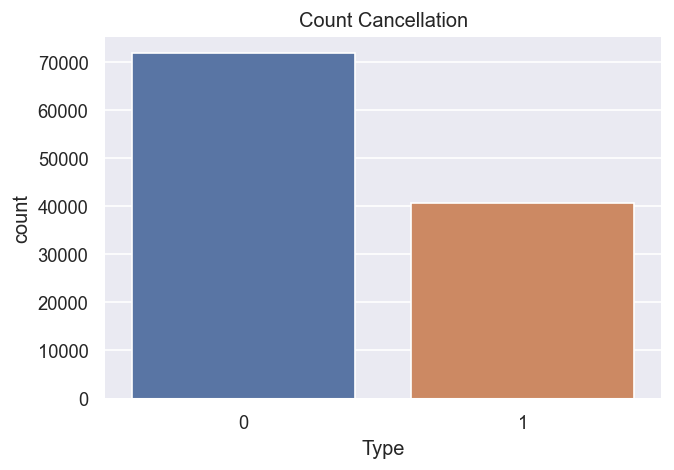

In [394]:
sns.countplot(x='cancellation',data=df)
plt.title('Count Cancellation')
plt.xlabel('Type')
plt.show()

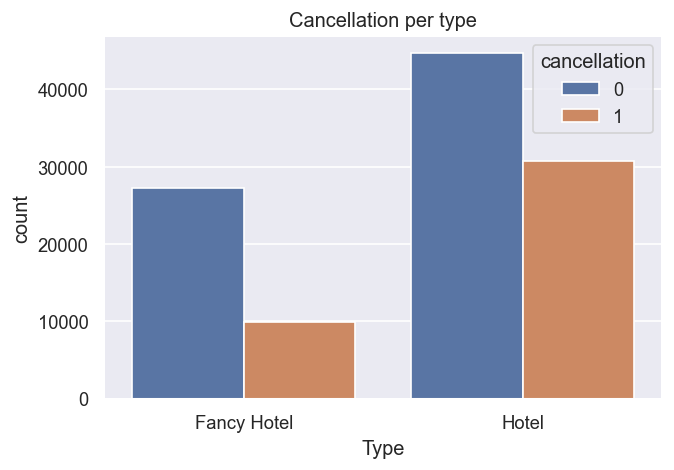

In [395]:
sns.countplot(x='type',data=df, hue='cancellation')
plt.title('Cancellation per type')
plt.xlabel('Type')
plt.show()

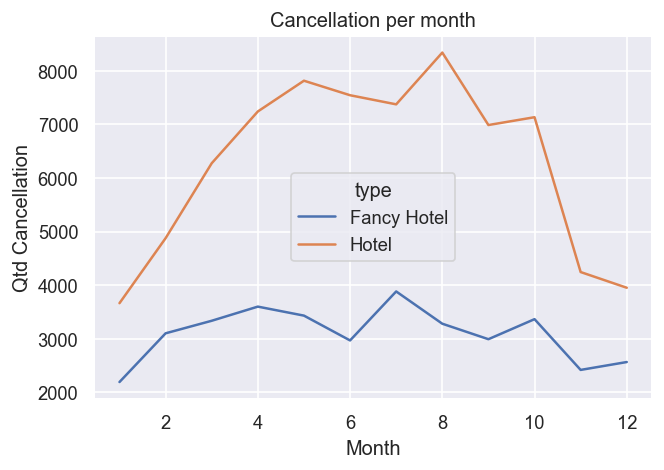

In [396]:
sns.lineplot(x='month_arrival_date_number',y='cancellation',data=df.groupby(['type','month_arrival_date_number']).count().reset_index()[['month_arrival_date_number','cancellation','type']], hue='type')
plt.title('Cancellation per month')
#change the x axis to month
plt.xlabel('Month')
plt.ylabel('Qtd Cancellation')
#plt.xticks (np.arange(1,13), ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
#plt.xticks(rotation=45)
plt.show()

Podemos identificar que os meses com menor número de reservas são os meses de Janeiro e Fevereiro. E o mês com maior número de reservas é o mês de Agosto.

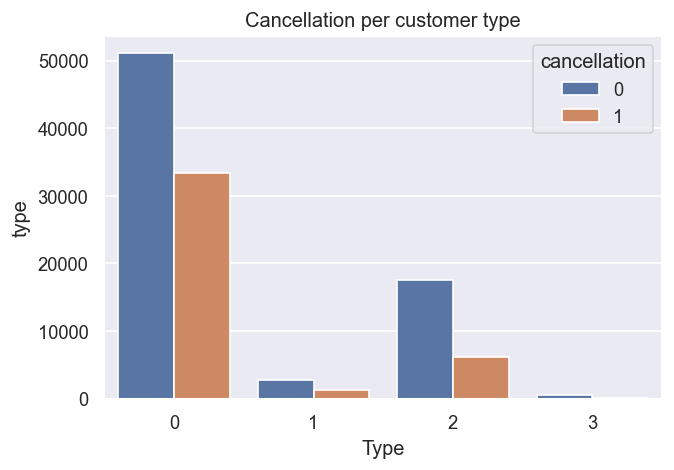

In [397]:
sns.barplot(x='customer_type',y = 'type', data= df.groupby(['customer_type','cancellation']).count().reset_index()[['customer_type','cancellation','type']], hue='cancellation')
plt.title('Cancellation per customer type')
plt.xlabel('Type')
plt.show()


Podemos identificar que o tipo de cliente que mais cancela é o cliente do type 0. Em contra partida, o tipo 2 proporcionalmente menos cancela.

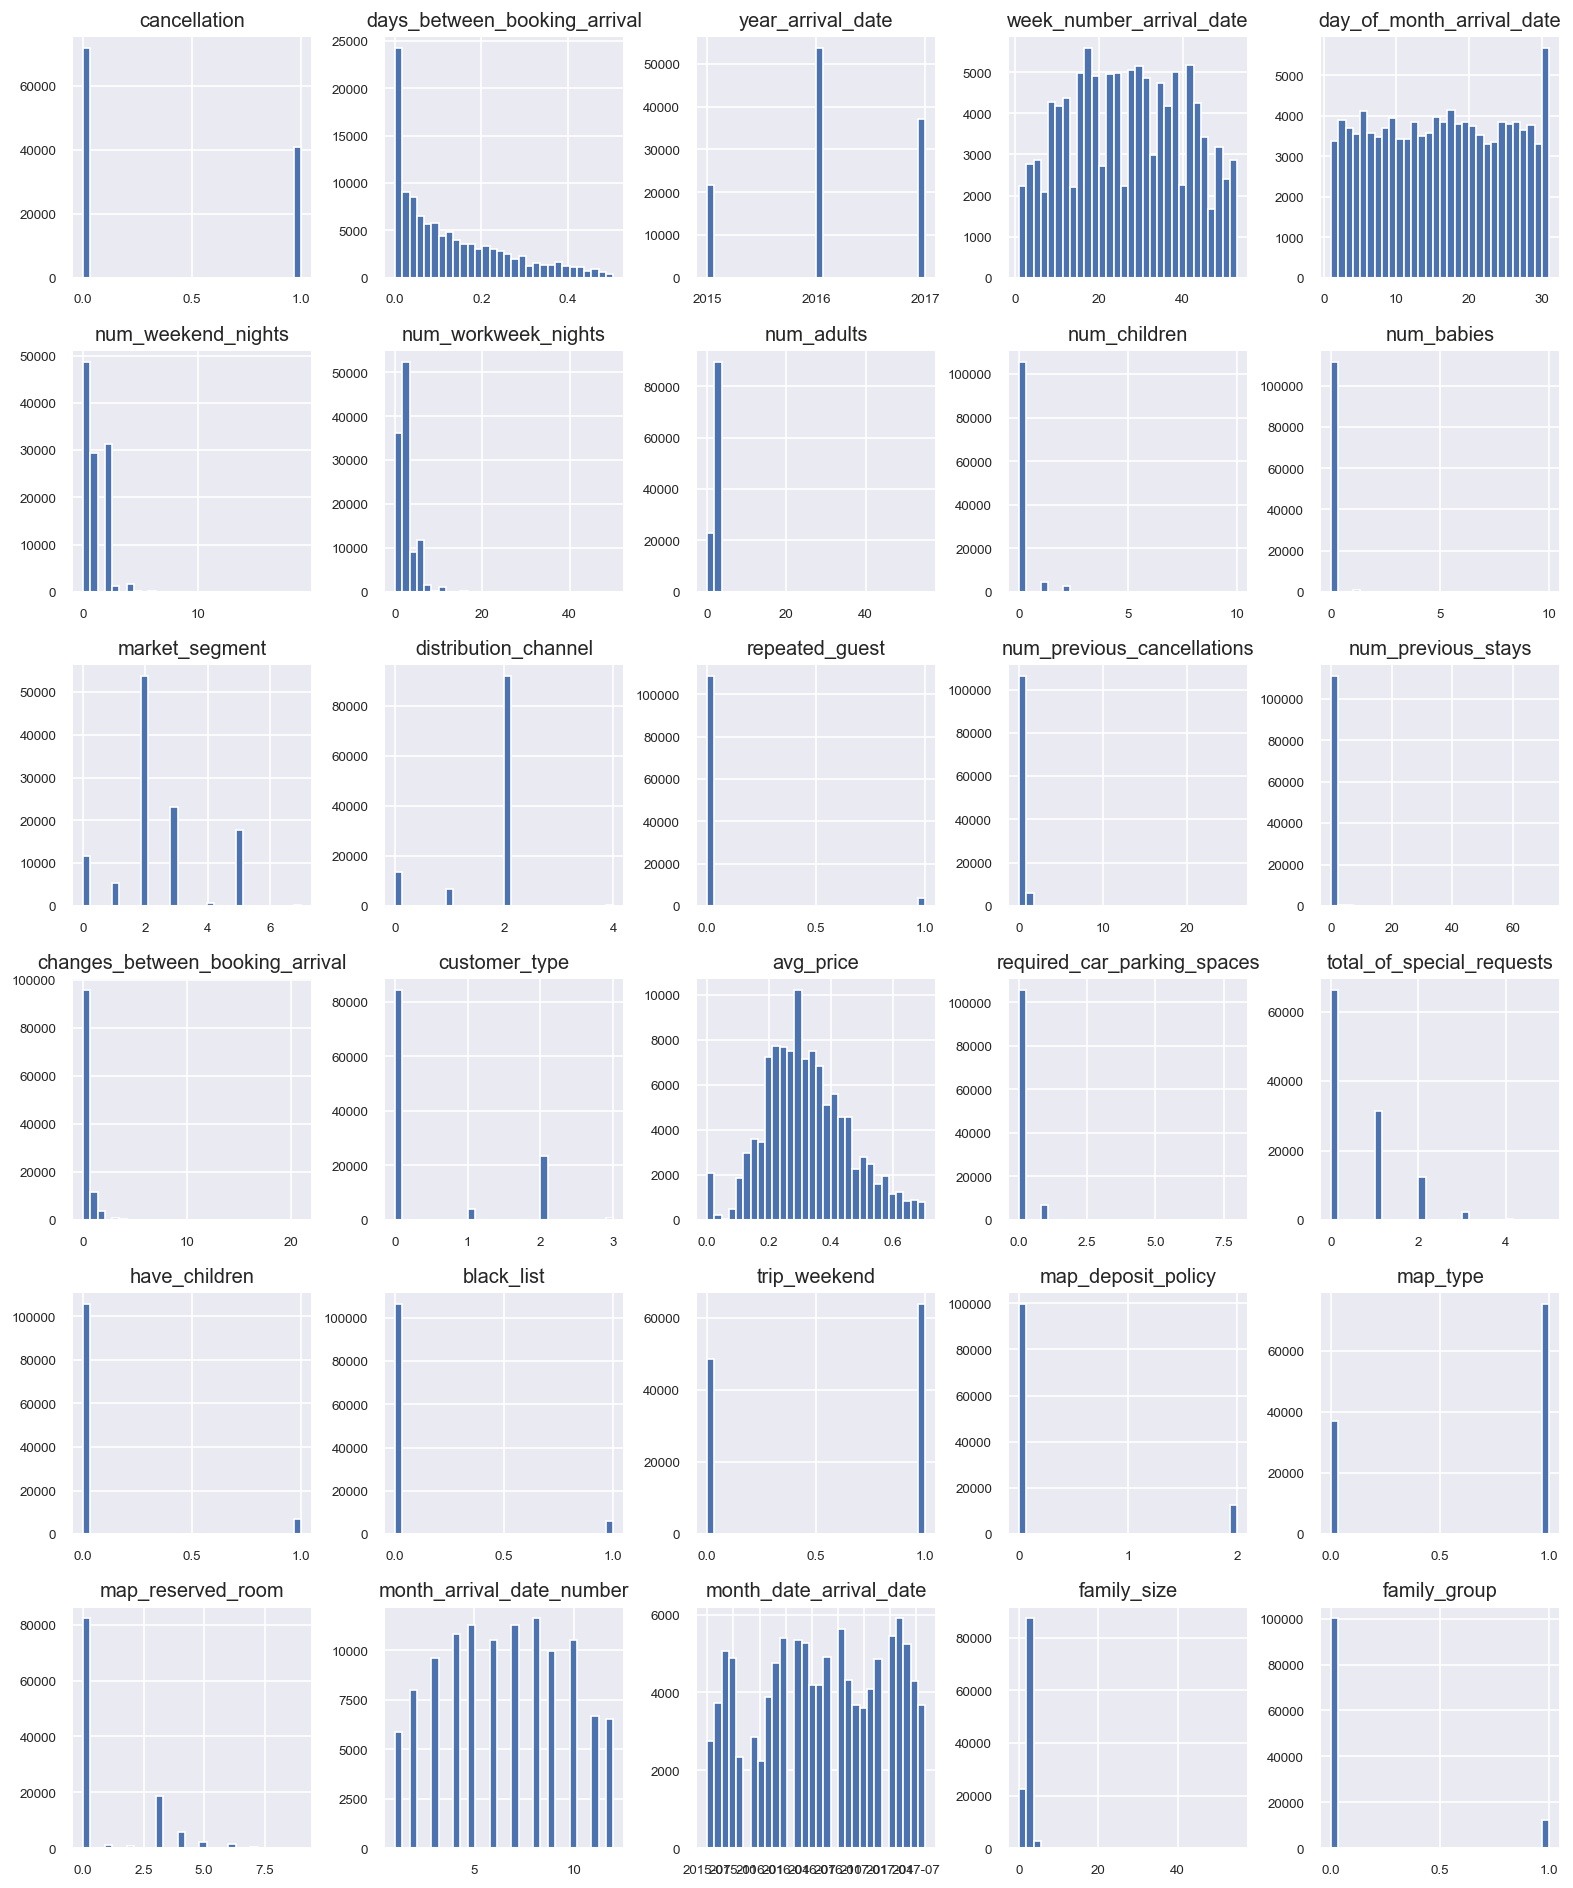

In [398]:
df.hist(figsize=(16, 20),bins=30, xlabelsize=8, ylabelsize=8);

É possível verificar que a variável de preço tem um comportamento similar a distribuição normal. Já a variável de semana do ano possui os valores distribuídos.

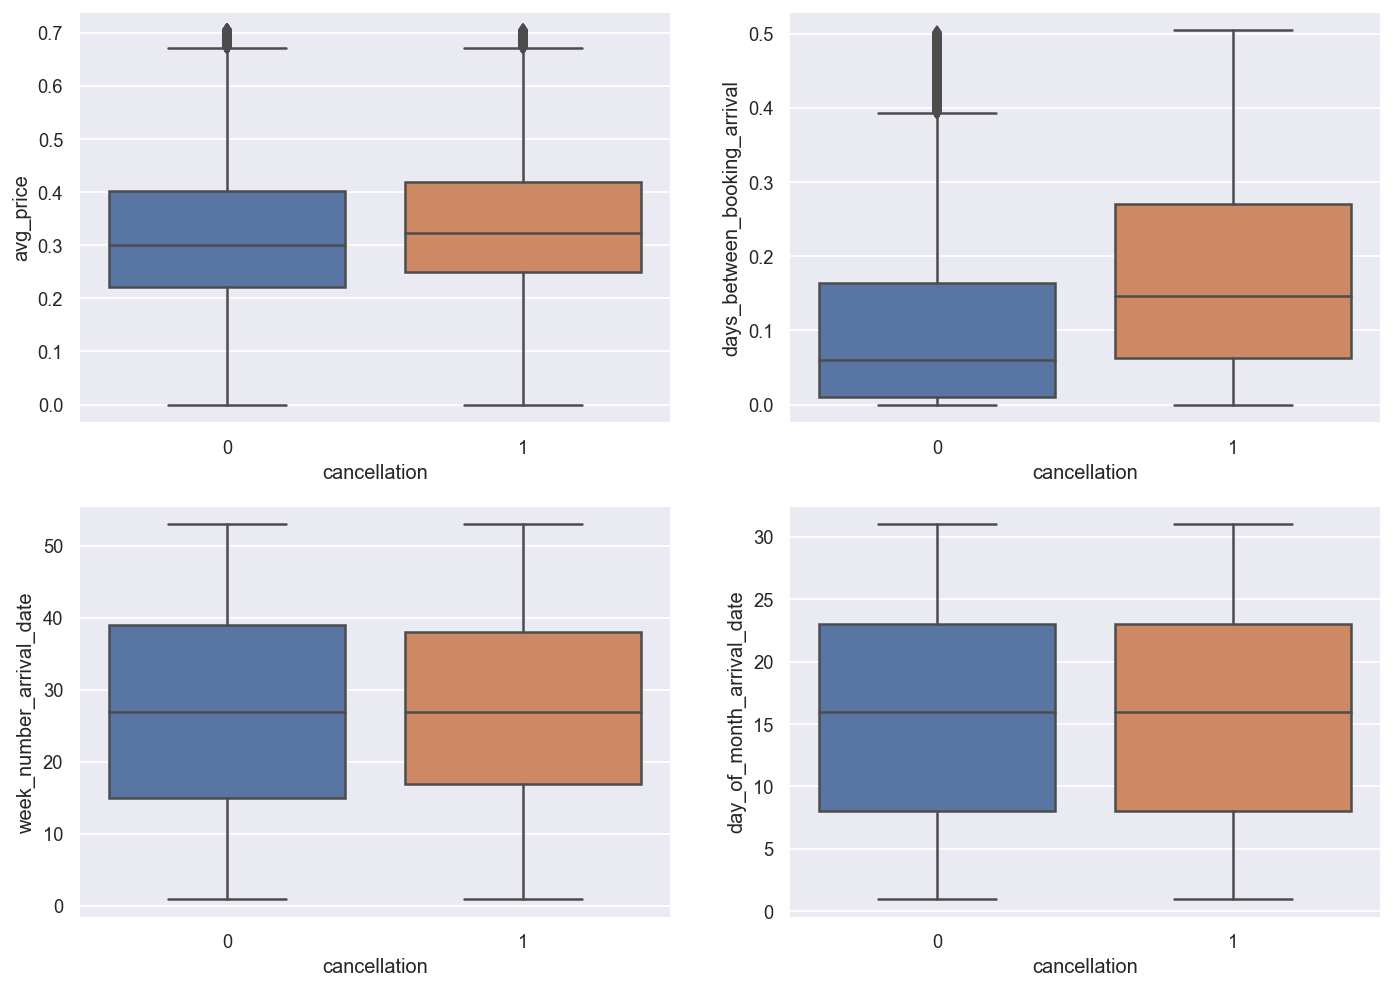

In [399]:
f, axes = plt.subplots(2,2,figsize = (14,10))
for i,col in enumerate(['avg_price', 'days_between_booking_arrival', 'week_number_arrival_date','day_of_month_arrival_date']):
    sns.boxplot(x='cancellation',y=col,data=df,ax=axes[i//2,i%2])

O Boxplot de days_between_booking_arrival com cancelamento possui uma mediana muito maior que o sem cancelamento.

Pela imagem é possível ver que o dataset é desbalanceado, pois existem muitos registros com status de cancelamento igual a 0.

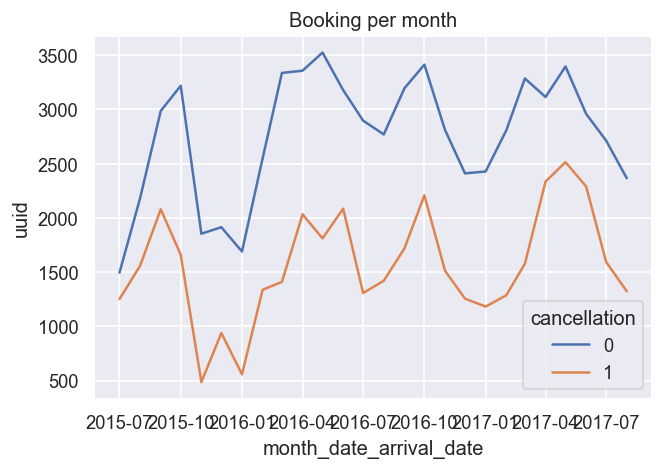

In [400]:
temp = df.groupby(['cancellation','month_date_arrival_date','month_and_year_arrival_date']).count().reset_index()[['uuid','cancellation','month_date_arrival_date','month_and_year_arrival_date']].sort_values(by=['month_date_arrival_date'])
sns.lineplot(x='month_date_arrival_date',y='uuid',data=temp,hue='cancellation')
plt.title('Booking per month')
#plt.xticks(rotation=45)
plt.show()

Claramente é possível er uma sazonalidade, é interessante verificar também que ele encontra-se em uma linha te tendência de alta. Podemos pensar no futuro de aplicar um modelo de séries temporais para prever o número de reservas por mês.

In [401]:
temp = df.groupby(['cancellation','country']).count().reset_index()[['uuid','cancellation','country']].sort_values(by=['uuid'], ascending=False)
temp_cancellation = temp[temp['cancellation']==1]
temp_not_cancellation = temp[temp['cancellation']==0]

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=temp_cancellation.head(10).country.values.tolist(), values=temp_cancellation.head(10).uuid.values.tolist(), name="Cancellation"),
              1, 1)
fig.add_trace(go.Pie(labels=temp_not_cancellation.head(10).country.values.tolist(), values=temp_not_cancellation.head(10).uuid.values.tolist(), name="Not Cancellation"),
              1, 2)

fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(
    title_text="Origin of bookings per cancellation status",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Cancel', x=0.20, y=0.5, font_size=18, showarrow=False),
                 dict(text='Not Cancel', x=0.815, y=0.5, font_size=18, showarrow=False)])
fig.show()


In [402]:
df.head()

,type,cancellation,days_between_booking_arrival,year_arrival_date,month_arrival_date,week_number_arrival_date,day_of_month_arrival_date,num_weekend_nights,num_workweek_nights,num_adults,...,black_list,trip_weekend,map_deposit_policy,map_type,map_reserved_room,month_arrival_date_number,month_and_year_arrival_date,month_date_arrival_date,family_size,family_group
0,Fancy Hotel,0,0.464043,2015,July,27,1,0,0,2,...,0,0,0,0,2,7,7/2015,2015-07-01,2.0,0
2,Fancy Hotel,0,0.009498,2015,July,27,1,0,1,1,...,0,0,0,0,0,7,7/2015,2015-07-01,1.0,0
3,Fancy Hotel,0,0.017639,2015,July,27,1,0,1,1,...,0,0,0,0,0,7,7/2015,2015-07-01,1.0,0
4,Fancy Hotel,0,0.018996,2015,July,27,1,0,2,2,...,0,0,0,0,0,7,7/2015,2015-07-01,2.0,0
5,Fancy Hotel,0,0.018996,2015,July,27,1,0,2,2,...,0,0,0,0,0,7,7/2015,2015-07-01,2.0,0


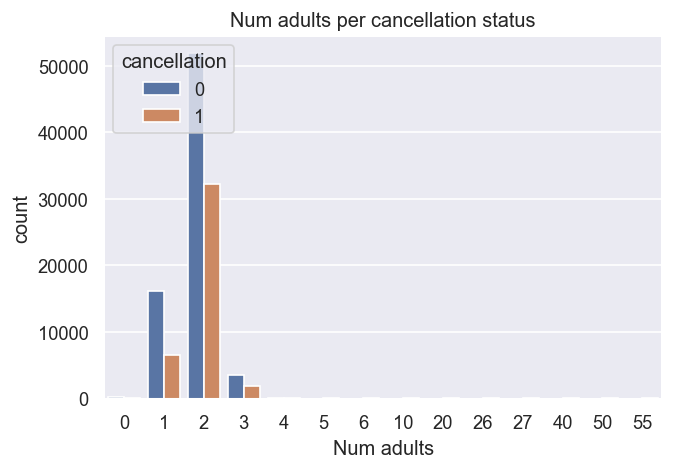

In [403]:


sns.countplot(x='num_adults',data=df, hue='cancellation')
plt.title('Num adults per cancellation status')
plt.xlabel('Num adults')
plt.show()


Adultos que viajam a dois tem maior probabilidade de cancelar

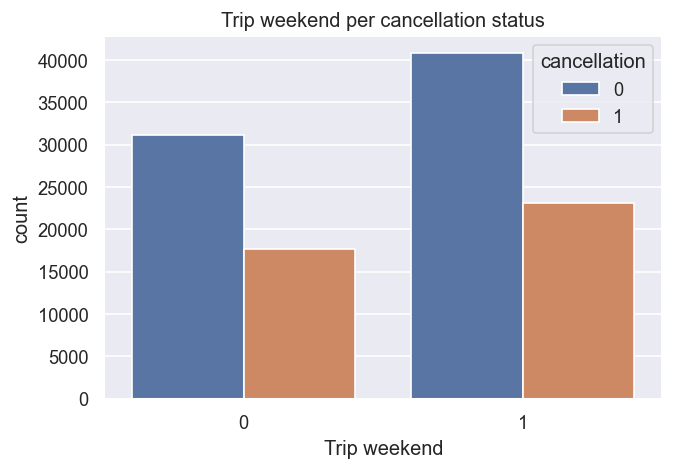

In [404]:

sns.countplot(x='trip_weekend',data=df, hue='cancellation')
plt.title('Trip weekend per cancellation status')
plt.xlabel('Trip weekend')
plt.show()


Proporcionalmente não temos influência significativa.

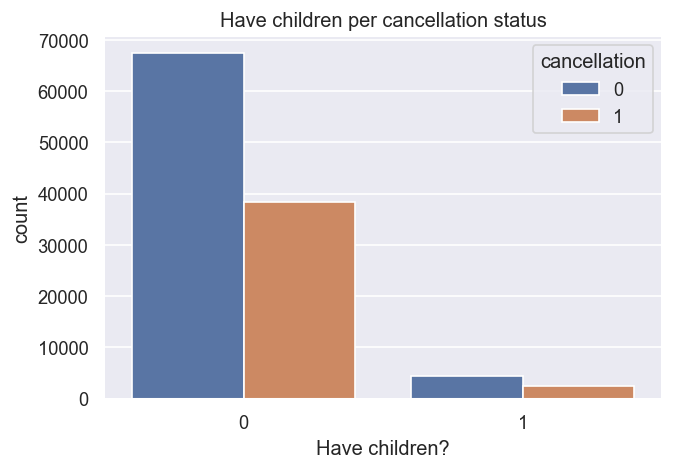

In [405]:
sns.countplot(x='have_children',data=df, hue='cancellation')
plt.title('Have children per cancellation status')
plt.xlabel('Have children?')
plt.show()

Proporcionalmente não temos influência significativa.

In [406]:
df.head()

,type,cancellation,days_between_booking_arrival,year_arrival_date,month_arrival_date,week_number_arrival_date,day_of_month_arrival_date,num_weekend_nights,num_workweek_nights,num_adults,...,black_list,trip_weekend,map_deposit_policy,map_type,map_reserved_room,month_arrival_date_number,month_and_year_arrival_date,month_date_arrival_date,family_size,family_group
0,Fancy Hotel,0,0.464043,2015,July,27,1,0,0,2,...,0,0,0,0,2,7,7/2015,2015-07-01,2.0,0
2,Fancy Hotel,0,0.009498,2015,July,27,1,0,1,1,...,0,0,0,0,0,7,7/2015,2015-07-01,1.0,0
3,Fancy Hotel,0,0.017639,2015,July,27,1,0,1,1,...,0,0,0,0,0,7,7/2015,2015-07-01,1.0,0
4,Fancy Hotel,0,0.018996,2015,July,27,1,0,2,2,...,0,0,0,0,0,7,7/2015,2015-07-01,2.0,0
5,Fancy Hotel,0,0.018996,2015,July,27,1,0,2,2,...,0,0,0,0,0,7,7/2015,2015-07-01,2.0,0


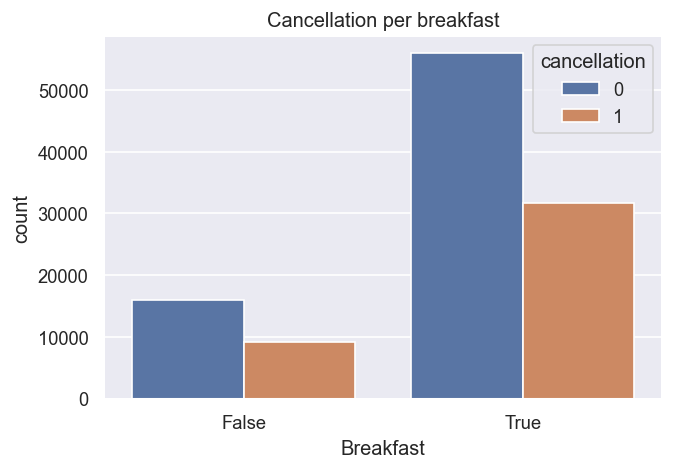

In [407]:
sns.countplot(x='breakfast',data=df, hue='cancellation')
plt.title('Cancellation per breakfast')
plt.xlabel('Breakfast')
plt.show()

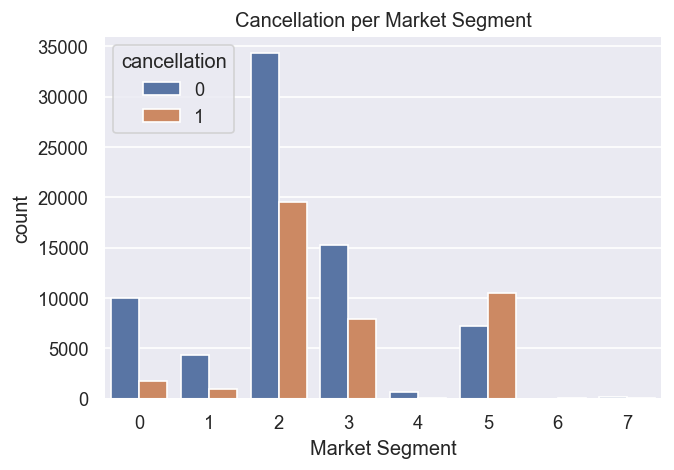

In [408]:
sns.countplot(x='market_segment',data=df, hue='cancellation')
plt.title('Cancellation per Market Segment')
plt.xlabel('Market Segment')
plt.show()

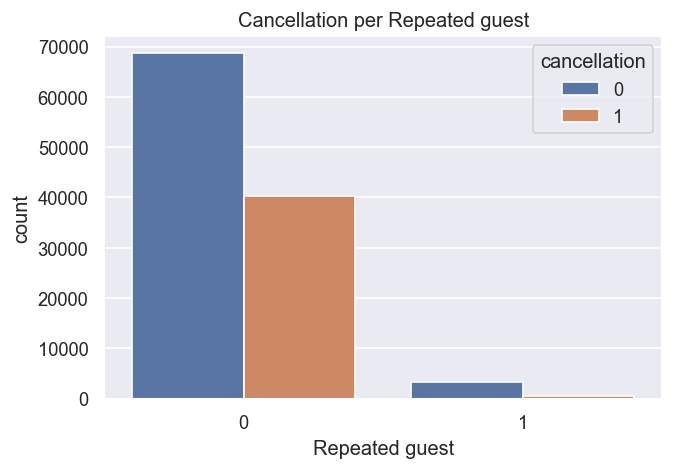

In [409]:
sns.countplot(x='repeated_guest',data=df, hue='cancellation')
plt.title('Cancellation per Repeated guest')
plt.xlabel('Repeated guest')
plt.show()

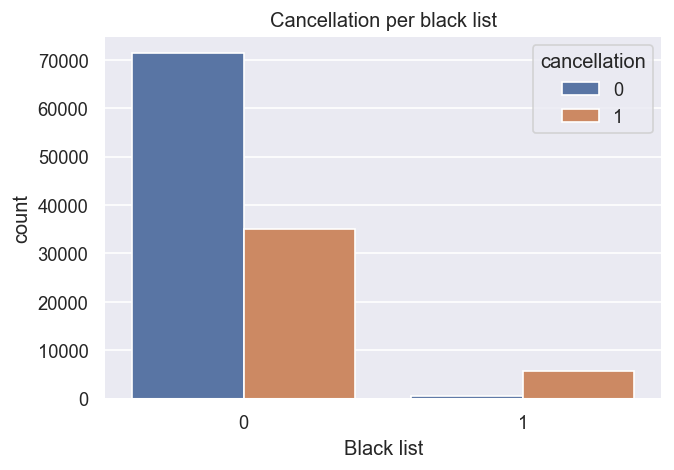

In [410]:
sns.countplot(x='black_list',data=df, hue='cancellation')
plt.title('Cancellation per black list')
plt.xlabel('Black list')
plt.show()


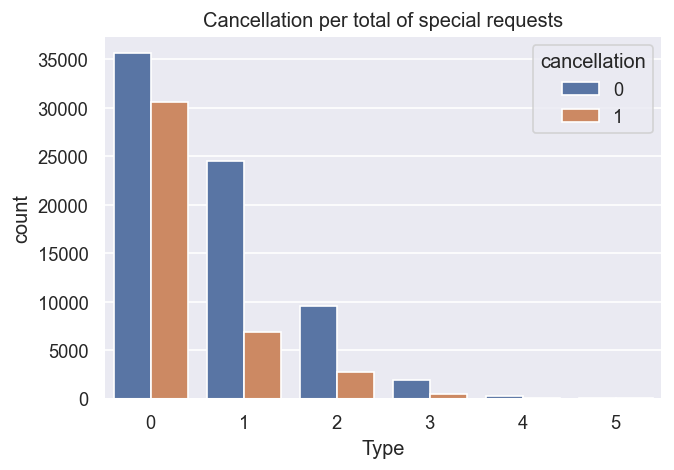

In [411]:
sns.countplot(x='total_of_special_requests',data=df, hue='cancellation')
plt.title('Cancellation per total of special requests')
plt.xlabel('Type')
plt.show()

Pessoas que fazem poucas exigências são mais prováveis de cancelar.

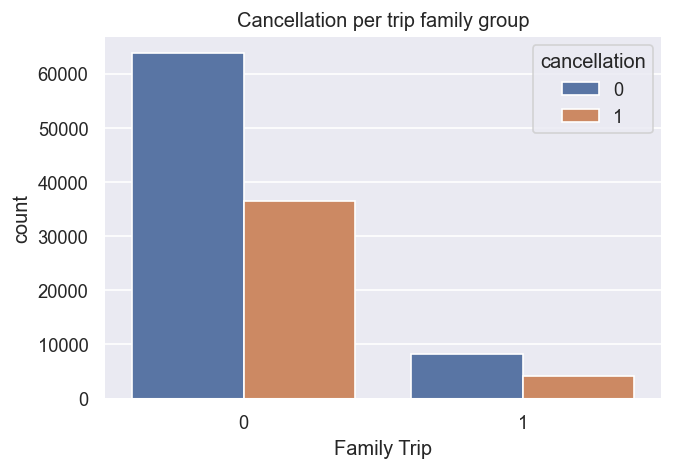

In [412]:
sns.countplot(x='family_group',data=df, hue='cancellation')
plt.title('Cancellation per trip family group')
plt.xlabel('Family Trip')
plt.show()

Interessante que proporcionalmente viajar em grupo ou em apenas uma pessoa não afeta o cancelamento. Ambas possuem uma tendência similar

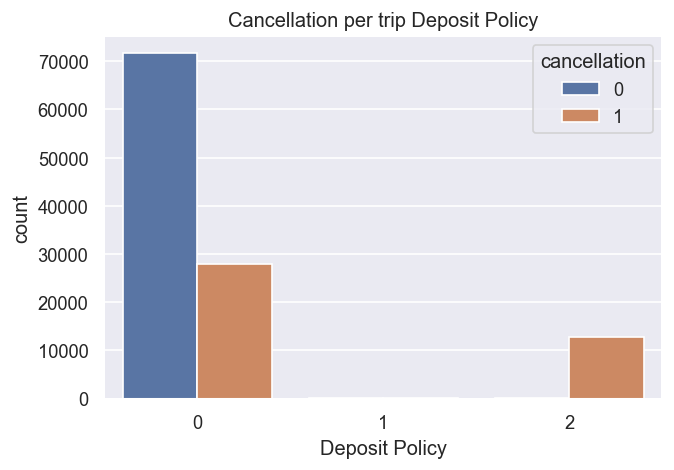

In [413]:
sns.countplot(x='map_deposit_policy',data=df, hue='cancellation')
plt.title('Cancellation per trip Deposit Policy')
plt.xlabel('Deposit Policy')
plt.show()

deposit_policy = {'No Deposit':0, 'Refundable':1, 'Non Refund':2}
Um fator curioso é que há um grande número de reservas sem reembolso que foram canceladas.

In [414]:
df.head()

,type,cancellation,days_between_booking_arrival,year_arrival_date,month_arrival_date,week_number_arrival_date,day_of_month_arrival_date,num_weekend_nights,num_workweek_nights,num_adults,...,black_list,trip_weekend,map_deposit_policy,map_type,map_reserved_room,month_arrival_date_number,month_and_year_arrival_date,month_date_arrival_date,family_size,family_group
0,Fancy Hotel,0,0.464043,2015,July,27,1,0,0,2,...,0,0,0,0,2,7,7/2015,2015-07-01,2.0,0
2,Fancy Hotel,0,0.009498,2015,July,27,1,0,1,1,...,0,0,0,0,0,7,7/2015,2015-07-01,1.0,0
3,Fancy Hotel,0,0.017639,2015,July,27,1,0,1,1,...,0,0,0,0,0,7,7/2015,2015-07-01,1.0,0
4,Fancy Hotel,0,0.018996,2015,July,27,1,0,2,2,...,0,0,0,0,0,7,7/2015,2015-07-01,2.0,0
5,Fancy Hotel,0,0.018996,2015,July,27,1,0,2,2,...,0,0,0,0,0,7,7/2015,2015-07-01,2.0,0


#### 2.5 - Teste de hipóteses

#### 2.5.1 - Teste de hipóteses - Chi-Square

In [415]:
_temp = df.groupby(['cancellation','breakfast']).count().reset_index()[['cancellation','breakfast','uuid']]
_temp.set_index(_temp.cancellation, inplace=True)
_temp.drop('cancellation',axis=1,inplace=True)
_temp.pivot(columns='breakfast',values='uuid').values.tolist()

[[15920, 55939], [9107, 31622]]

In [416]:

stat, p, dof, expected = chi2_contingency(_temp.pivot(columns='breakfast',values='uuid').values)
prob = chi2.sf(stat, dof)
if abs(prob) < 0.05:
    print('Reject Null Hypothesis')
else:
    print('Cannot Reject Null Hypothesis')
print(p)

Cannot Reject Null Hypothesis
0.42988593314126544


#### 2.5.2 - Teste de hipótesis - Normality

In [417]:
stat, p = shapiro(df[df.cancellation==0].avg_price.values)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.986, p=0.000
Sample does not look Gaussian (reject H0)


In [418]:
stat, p = shapiro(df[df.cancellation==1].avg_price.values)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.980, p=0.000
Sample does not look Gaussian (reject H0)


#### 2.5.3 - Teste de hipótesis - Mann Whitneyu

In [419]:
from scipy.stats import mannwhitneyu
_temp_avg_cancellation = df[df.cancellation==1].avg_price.values
_temp_avg_not_cancellation = df[df.cancellation==0].avg_price.values

U1, p = mannwhitneyu(_temp_avg_cancellation, _temp_avg_not_cancellation)
if p < 0.05:
    print('Reject Null Hypothesis')
else:
    print('Cannot Reject Null Hypothesis')



Reject Null Hypothesis


## 3 Feature Engineering

### 3.1 Selecting features

In [420]:
#correlation with target
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')


,cancellation,days_between_booking_arrival,year_arrival_date,week_number_arrival_date,day_of_month_arrival_date,num_weekend_nights,num_workweek_nights,num_adults,num_children,num_babies,breakfast,market_segment,distribution_channel,repeated_guest,num_previous_cancellations,num_previous_stays,changes_between_booking_arrival,customer_type,avg_price,required_car_parking_spaces,total_of_special_requests,have_children,black_list,trip_weekend,map_deposit_policy,map_type,map_reserved_room,month_arrival_date_number,family_size,family_group
cancellation,1.000000,0.287520,0.013146,0.005060,-0.005861,0.004771,0.027951,0.060301,0.003446,-0.030061,-0.002375,0.225005,0.164558,-0.083456,0.113157,-0.057317,-0.138402,-0.122496,0.073966,-0.189622,-0.221562,-0.004720,0.278909,-0.000439,0.468744,0.137096,-0.062815,0.007883,0.048119,-0.015132
days_between_booking_arrival,0.287520,1.000000,0.011630,0.125568,-0.001980,0.134745,0.221921,0.140210,-0.015433,-0.016316,-0.051810,0.350448,0.197641,-0.130417,0.104660,-0.078982,0.011020,0.159658,-0.005591,-0.115195,-0.070331,-0.015945,0.246125,0.103805,0.321633,0.046567,-0.068197,0.130226,0.107365,-0.014187
year_arrival_date,0.013146,0.011630,1.000000,-0.554313,-0.001985,0.020209,0.031539,0.019454,0.033682,-0.013308,-0.030201,-0.124476,0.009870,0.014270,-0.118363,0.032143,0.028232,-0.211991,0.191853,-0.014342,0.104497,0.042003,-0.267910,0.025953,-0.070746,0.039862,0.077825,-0.542215,0.031569,0.061466
week_number_arrival_date,0.005060,0.125568,-0.554313,1.000000,0.064478,0.020820,0.013979,0.023019,-0.001307,0.010434,0.006402,0.025584,0.016017,-0.029177,0.036144,-0.019936,0.003916,0.061705,0.071226,-0.000946,0.026909,0.000571,0.083509,0.028215,0.000331,0.011999,-0.015738,0.995228,0.020058,0.002581
day_of_month_arrival_date,-0.005861,-0.001980,-0.001985,0.064478,1.000000,-0.018294,-0.027847,-0.003804,0.013360,-0.000526,0.013822,0.003959,-0.004207,-0.006257,-0.027594,0.000120,0.009928,-0.001969,0.025172,0.008174,0.000601,0.014888,-0.012234,-0.002144,-0.005577,-0.000383,0.013397,-0.027346,0.003527,0.014600
num_weekend_nights,0.004771,0.134745,0.020209,0.020820,-0.018294,1.000000,0.502487,0.092982,0.039824,0.017781,-0.058472,0.012740,0.072408,-0.091419,-0.013046,-0.044311,0.061305,-0.043038,0.032706,-0.024426,0.066543,0.039416,-0.055302,0.812949,-0.099079,-0.178809,0.139081,0.021050,0.100570,0.044415
num_workweek_nights,0.027951,0.221921,0.031539,0.013979,-0.027847,0.502487,1.000000,0.092231,0.036498,0.018678,-0.054950,0.007912,0.064005,-0.100429,-0.013348,-0.049922,0.095297,-0.032654,0.048551,-0.031675,0.064393,0.035174,-0.056629,0.181931,-0.068688,-0.221420,0.164696,0.017645,0.098375,0.044430
num_adults,0.060301,0.140210,0.019454,0.023019,-0.003804,0.092982,0.092231,1.000000,0.015906,0.018496,-0.035771,-0.027113,0.086175,-0.147665,-0.004393,-0.108461,-0.054536,-0.089409,0.231387,0.008262,0.122444,0.034260,-0.026670,0.099654,-0.030149,-0.005202,0.197741,0.025555,0.848327,0.371826
num_children,0.003446,-0.015433,0.033682,-0.001307,0.013360,0.039824,0.036498,0.015906,1.000000,0.024611,0.057210,-0.119732,-0.021908,-0.030602,-0.022839,-0.019533,0.048489,-0.080786,0.239094,0.044622,0.085295,0.935426,-0.050446,0.034471,-0.085436,-0.027819,0.310551,-0.002050,0.524647,0.628687
num_babies,-0.030061,-0.016316,-0.013308,0.010434,-0.000526,0.017781,0.018678,0.018496,0.024611,1.000000,-0.004425,-0.041266,-0.039366,-0.008655,-0.007351,-0.006518,0.079088,-0.021448,0.020172,0.034240,0.093772,0.034460,-0.015740,0.015618,-0.028670,-0.041994,0.033977,0.010311,0.165890,0.224532


In [421]:
list_features =['days_between_booking_arrival','map_type',
'customer_type','black_list','repeated_guest',
'market_segment','breakfast','num_adults','map_deposit_policy']
target = ['cancellation']

In [422]:
df[list_features].head()

,days_between_booking_arrival,map_type,customer_type,black_list,repeated_guest,market_segment,breakfast,num_adults,map_deposit_policy
0,0.464043,0,0,0,0,0,True,2,0
2,0.009498,0,0,0,0,0,True,1,0
3,0.017639,0,0,0,0,1,True,1,0
4,0.018996,0,0,0,0,2,True,2,0
5,0.018996,0,0,0,0,2,True,2,0


In [423]:
X = df[list_features]
y = df[target]

#### 3.2 One Hot Encoding

In [424]:
X = pd.concat([X,pd.get_dummies(X.market_segment,drop_first=True,prefix='market_segment')], axis=1)
X.drop('market_segment',axis=1,inplace=True)

#### 3.3 Balancing the dataset

In [425]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (112588, 15)
Shape of X after SMOTE: (143718, 15)

Balance of positive and negative classes (%):


cancellation
0               50.0
1               50.0
dtype: float64

In [426]:
X.head()

,days_between_booking_arrival,map_type,customer_type,black_list,repeated_guest,breakfast,num_adults,map_deposit_policy,market_segment_1,market_segment_2,market_segment_3,market_segment_4,market_segment_5,market_segment_6,market_segment_7
0,0.464043,0,0,0,0,True,2,0,0,0,0,0,0,0,0
2,0.009498,0,0,0,0,True,1,0,0,0,0,0,0,0,0
3,0.017639,0,0,0,0,True,1,0,1,0,0,0,0,0,0
4,0.018996,0,0,0,0,True,2,0,0,1,0,0,0,0,0
5,0.018996,0,0,0,0,True,2,0,0,1,0,0,0,0,0


In [427]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV


#### 3.3 Split Train and Test

In [428]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42,shuffle=True)

### 4 Modeling

#### 4.1 Baseline model : Logistic Regression

In [429]:

lreg = LogisticRegression()
lreg.fit(X_train, y_train)
y_pred = lreg.predict(X_test)
print(f'The accuracy model: {metrics.accuracy_score(y_test, y_pred)}')

The accuracy model: 0.7273170052880601


In [430]:
metrics.confusion_matrix(y_test, y_pred)

array([[12101,  2420],
       [ 5418,  8805]], dtype=int64)

Text(0, 0.5, 'Frequency')

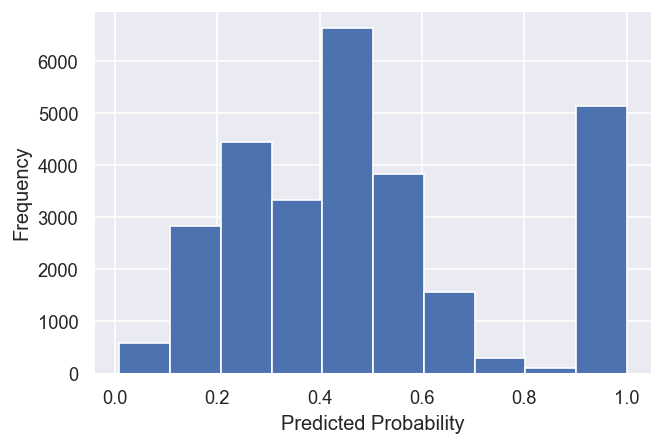

In [431]:
y_pred_proba = lreg.predict_proba(X_test)
pos_proba = y_pred_proba[:, 1]


plt.hist(pos_proba)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

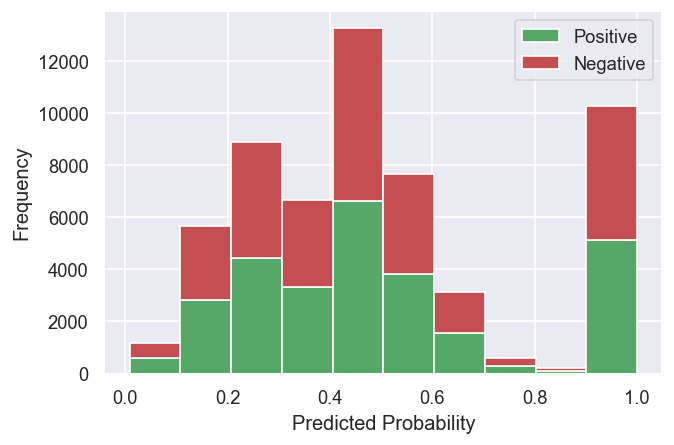

In [432]:
pos_sample_pos_proba = pos_proba[pd.DataFrame(y_test==1).reset_index()['cancellation'].index.tolist()]
neg_sample_pos_proba = pos_proba[pd.DataFrame(y_test==0).reset_index()['cancellation'].index.tolist()]

plt.hist([pos_sample_pos_proba, neg_sample_pos_proba], stacked=True, color=['g', 'r'])
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend(['Positive', 'Negative'])

Text(0.5, 1.0, 'ROC curve')

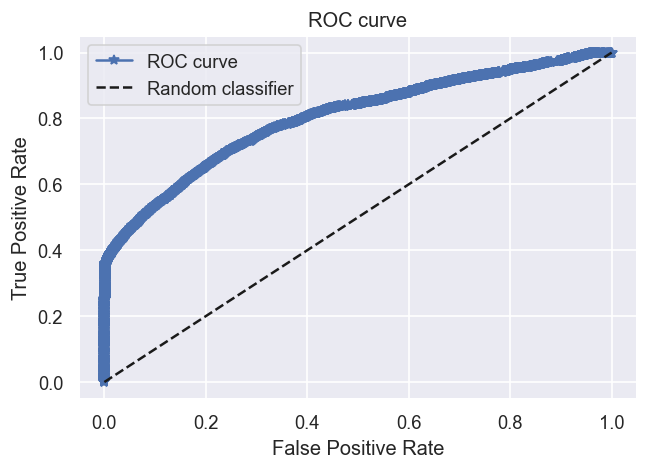

In [433]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, '*-')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(['ROC curve', 'Random classifier'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

(0.0, 1.0)

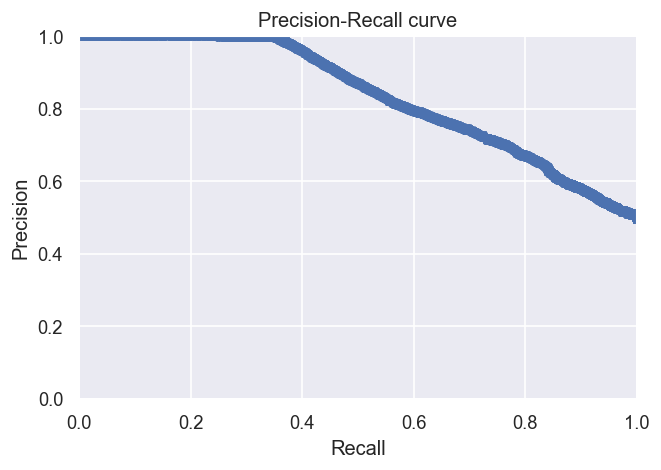

In [434]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_proba[:, 1])
plt.plot(recall, precision, '*-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.xlim([0, 1])
plt.ylim([0, 1])

In [435]:
print(f'The area under the precision-recall curve is: {metrics.auc(recall, precision)}')
print(f'The threshold for the model is {thresholds[-1]}')
print(f'The probability for the model is {pos_proba[-1] > thresholds[-1]}')
print('The AUC Score is: ', metrics.roc_auc_score(y_test, pos_proba))

The area under the precision-recall curve is: 0.836081808947702
The threshold for the model is 0.999944845400383
The probability for the model is False
The AUC Score is:  0.8018293981814931


#### 4.2 Model 2 : AdaBoost

In [436]:
adareg = AdaBoostClassifier(base_estimator=lreg, n_estimators=100, random_state=42)
adareg.fit(X_train, y_train)
y_pred = adareg.predict(X_test)
print(f'The accuracy model: {metrics.accuracy_score(y_test, y_pred)}')

The accuracy model: 0.71969802393543


In [437]:
metrics.confusion_matrix(y_test, y_pred)

array([[11388,  3133],
       [ 4924,  9299]], dtype=int64)

Text(0, 0.5, 'Frequency')

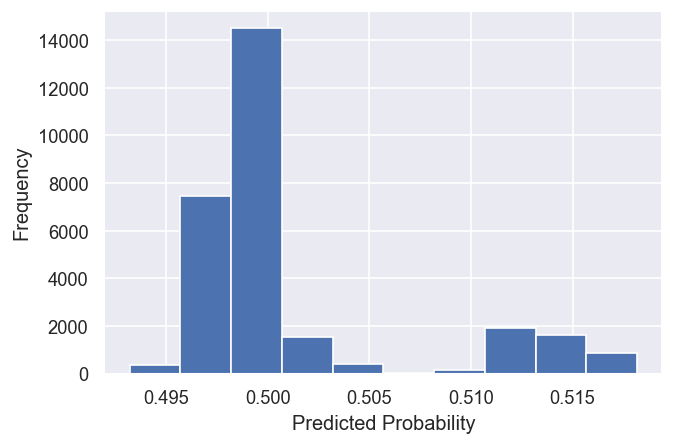

In [438]:
y_pred_proba = adareg.predict_proba(X_test)
pos_proba = y_pred_proba[:, 1]


plt.hist(pos_proba)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

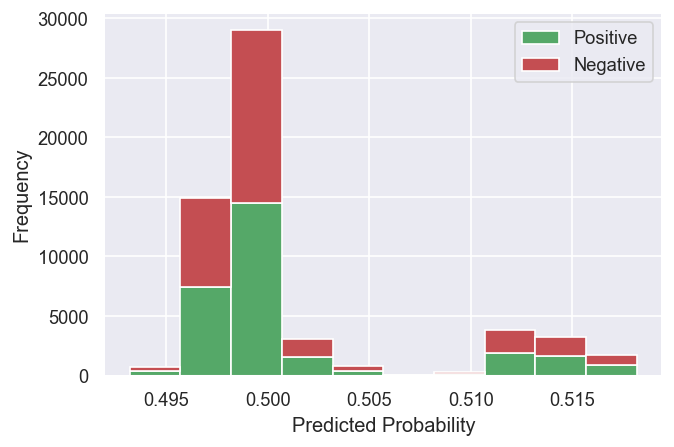

In [439]:
pos_sample_pos_proba = pos_proba[pd.DataFrame(y_test==1).reset_index()['cancellation'].index.tolist()]
neg_sample_pos_proba = pos_proba[pd.DataFrame(y_test==0).reset_index()['cancellation'].index.tolist()]

plt.hist([pos_sample_pos_proba, neg_sample_pos_proba], stacked=True, color=['g', 'r'])
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend(['Positive', 'Negative'])

Text(0.5, 1.0, 'ROC curve')

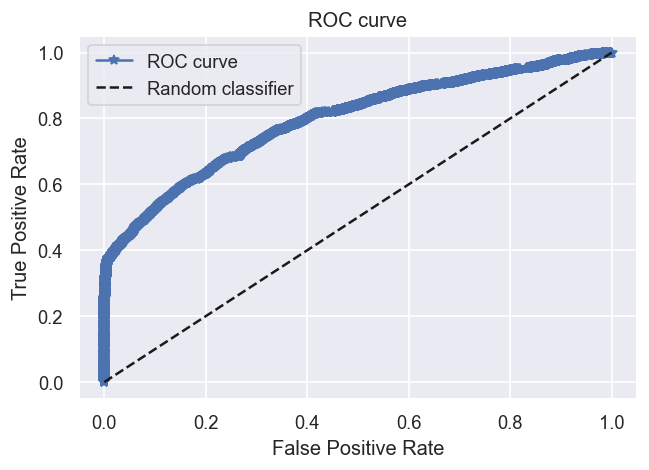

In [440]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, '*-')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(['ROC curve', 'Random classifier'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

(0.0, 1.0)

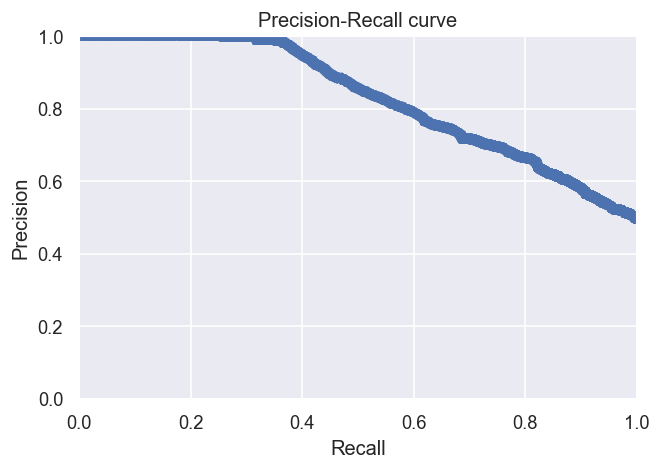

In [441]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_proba[:, 1])
plt.plot(recall, precision, '*-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.xlim([0, 1])
plt.ylim([0, 1])

In [442]:
print(f'The area under the precision-recall curve is: {metrics.auc(recall, precision)}')
print(f'The threshold for the model is {thresholds[-1]}')
print(f'The probability for the model is {pos_proba[-1] > thresholds[-1]}')
print('The AUC Score is: ', metrics.roc_auc_score(y_test, pos_proba))

The area under the precision-recall curve is: 0.8301071608589365
The threshold for the model is 0.5181708296060193
The probability for the model is False
The AUC Score is:  0.7955204298595924


#### 4.3 Model 3 : Gradient Boosting

In [443]:
gradreg = GradientBoostingClassifier(n_estimators=100, random_state=42)

In [444]:
gradreg.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [445]:
y_pred = gradreg.predict(X_test)
print(f'The accuracy model: {metrics.accuracy_score(y_test, y_pred)}')
metrics.confusion_matrix(y_test, y_pred)
y_pred_proba = gradreg.predict_proba(X_test)
pos_proba = y_pred_proba[:, 1]

The accuracy model: 0.7434247147230726


Text(0, 0.5, 'Frequency')

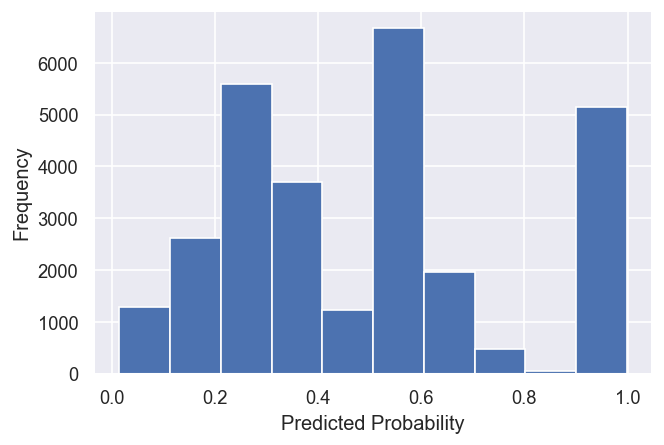

In [446]:
plt.hist(pos_proba)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

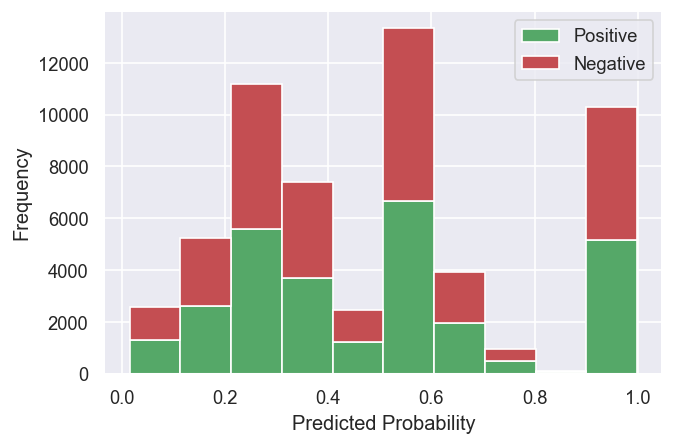

In [447]:
pos_sample_pos_proba = pos_proba[pd.DataFrame(y_test == 1).reset_index()['cancellation'].index.tolist()]
neg_sample_pos_proba = pos_proba[pd.DataFrame(y_test == 0).reset_index()['cancellation'].index.tolist()]

plt.hist([pos_sample_pos_proba, neg_sample_pos_proba], stacked=True, color=['g', 'r'])
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend(['Positive', 'Negative'])

Text(0.5, 1.0, 'ROC curve')

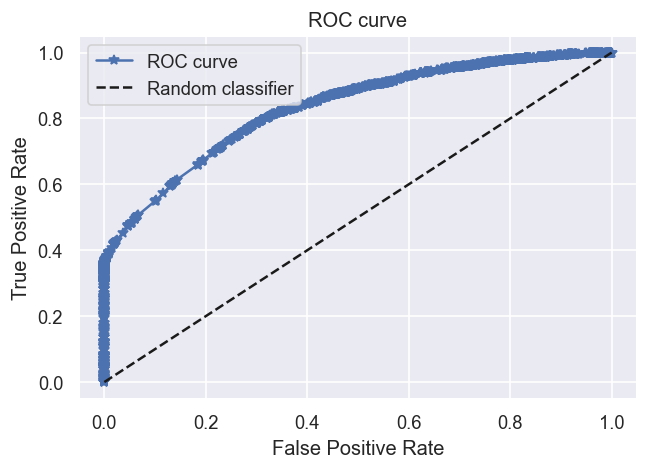

In [448]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, '*-')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(['ROC curve', 'Random classifier'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

(0.0, 1.0)

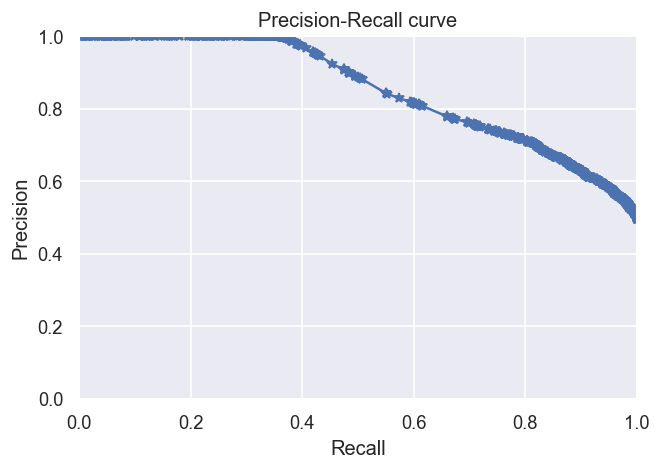

In [449]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_proba[:, 1])
plt.plot(recall, precision, '*-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.xlim([0, 1])
plt.ylim([0, 1])

In [450]:
print(f'The area under the precision-recall curve is: {metrics.auc(recall, precision)}')
print(f'The threshold for the model is {thresholds[-1]}')
print(f'The probability for the model is {pos_proba[-1] > thresholds[-1]}')
print('The AUC Score is: ', metrics.roc_auc_score(y_test, pos_proba))

The area under the precision-recall curve is: 0.8539883366618963
The threshold for the model is 0.9983874538414672
The probability for the model is False
The AUC Score is:  0.8319782007049236


#### 4.4 Model 4 : XGBoost

In [451]:
from xgboost import XGBClassifier
xgreg = XGBClassifier(n_estimators=100, random_state=42)


In [452]:
xgreg.fit(X_train, y_train)
y_pred = xgreg.predict(X_test)
print(f'The accuracy model: {metrics.accuracy_score(y_test, y_pred)}')

[22:09:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The accuracy model: 0.7644377957138881


In [453]:
metrics.confusion_matrix(y_test, y_pred)

array([[10716,  3805],
       [ 2966, 11257]], dtype=int64)

Text(0, 0.5, 'Frequency')

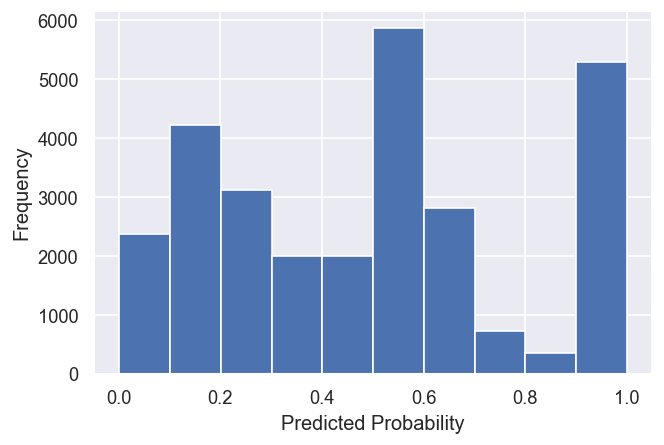

In [454]:
y_pred_proba = xgreg.predict_proba(X_test)
pos_proba = y_pred_proba[:, 1]
plt.hist(pos_proba)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

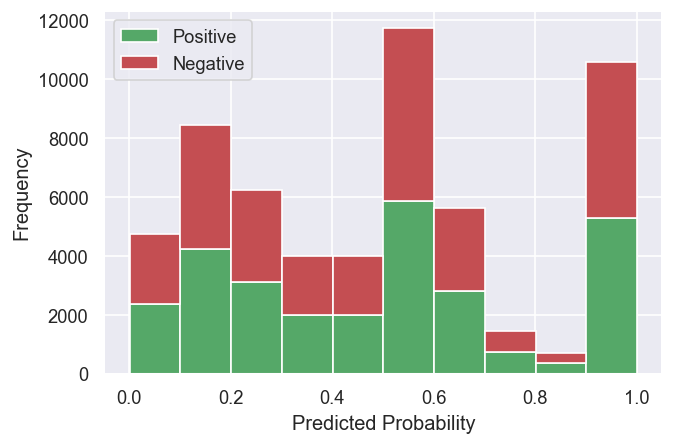

In [455]:
pos_sample_pos_proba = pos_proba[pd.DataFrame(y_test == 1).reset_index()['cancellation'].index.tolist()]
neg_sample_pos_proba = pos_proba[pd.DataFrame(y_test == 0).reset_index()['cancellation'].index.tolist()]

plt.hist([pos_sample_pos_proba, neg_sample_pos_proba], stacked=True, color=['g', 'r'])
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend(['Positive', 'Negative'])

Text(0.5, 1.0, 'ROC curve')

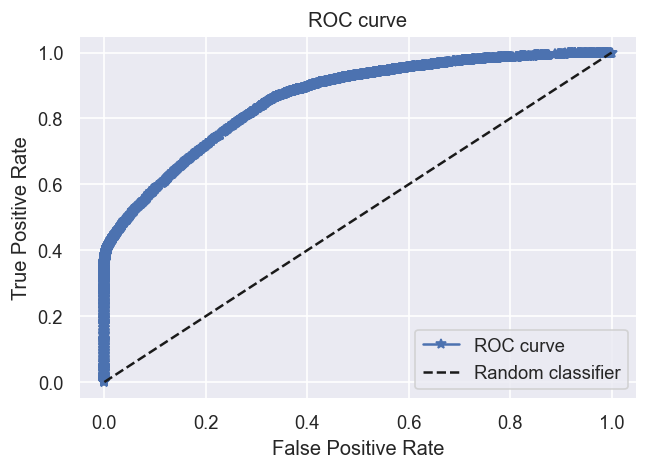

In [456]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, '*-')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(['ROC curve', 'Random classifier'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

(0.0, 1.0)

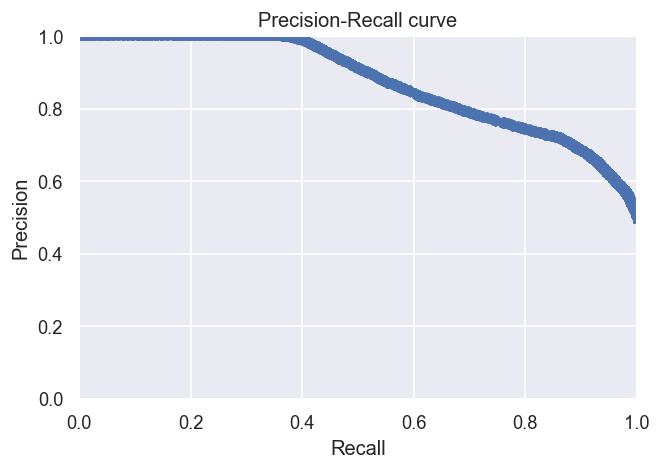

In [457]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_proba[:, 1])
plt.plot(recall, precision, '*-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.xlim([0, 1])
plt.ylim([0, 1])

In [458]:
print(f'The area under the precision-recall curve is: {metrics.auc(recall, precision)}')
print(f'The threshold for the model is {thresholds[-1]}')
print(f'The probability for the model is {pos_proba[-1] > thresholds[-1]}')
print('The AUC Score is: ', metrics.roc_auc_score(y_test, pos_proba))

The area under the precision-recall curve is: 0.8739665226960465
The threshold for the model is 0.9999977350234985
The probability for the model is False
The AUC Score is:  0.8601207105819435


#### 4.5 Model 5 : K-Nearest Neighbors

In [459]:
kreg = KNeighborsClassifier(n_neighbors=5)

kreg.fit(X_train, y_train)
y_pred = kreg.predict(X_test)
print(f'The accuracy model: {metrics.accuracy_score(y_test, y_pred)}')

The accuracy model: 0.7528527692735876


In [460]:
metrics.confusion_matrix(y_test, y_pred)

array([[11276,  3245],
       [ 3859, 10364]], dtype=int64)

Text(0, 0.5, 'Frequency')

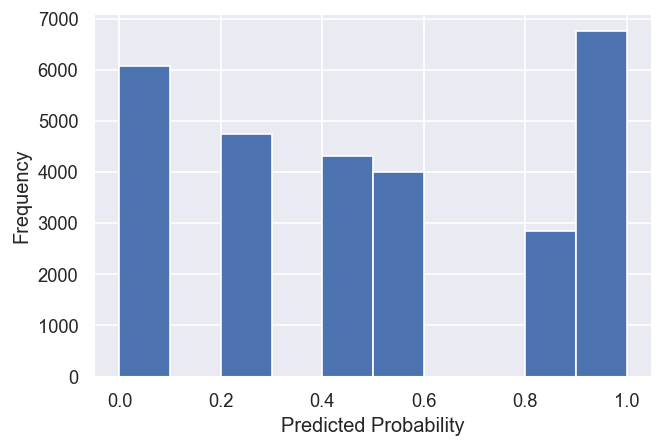

In [461]:
y_pred_proba = kreg.predict_proba(X_test)
pos_proba = y_pred_proba[:, 1]
plt.hist(pos_proba)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

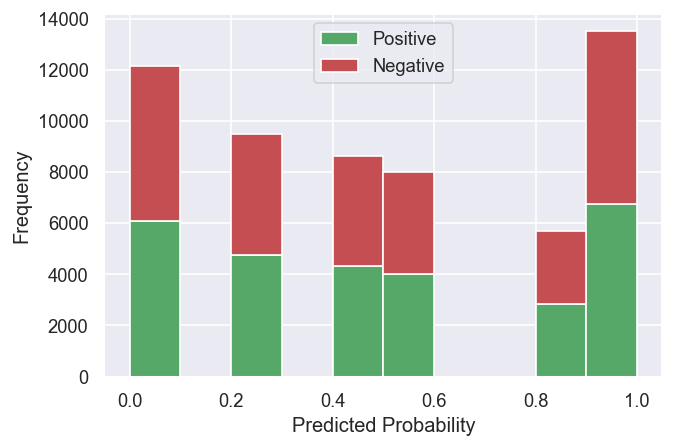

In [462]:
pos_sample_pos_proba = pos_proba[pd.DataFrame(y_test == 1).reset_index()['cancellation'].index.tolist()]
neg_sample_pos_proba = pos_proba[pd.DataFrame(y_test == 0).reset_index()['cancellation'].index.tolist()]

plt.hist([pos_sample_pos_proba, neg_sample_pos_proba], stacked=True, color=['g', 'r'])
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend(['Positive', 'Negative'])

Text(0.5, 1.0, 'ROC curve')

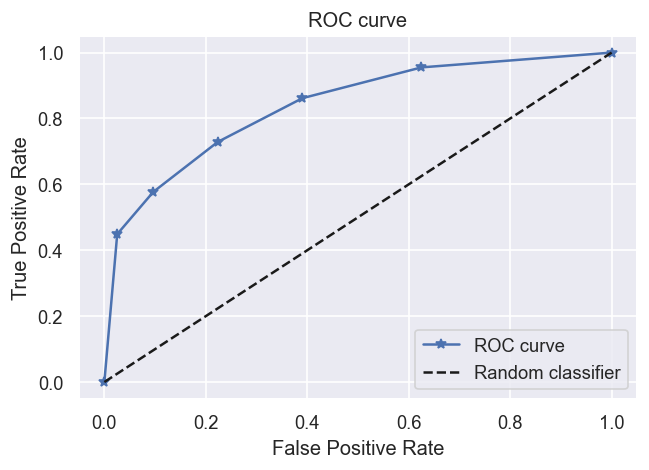

In [463]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, '*-')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(['ROC curve', 'Random classifier'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

(0.0, 1.0)

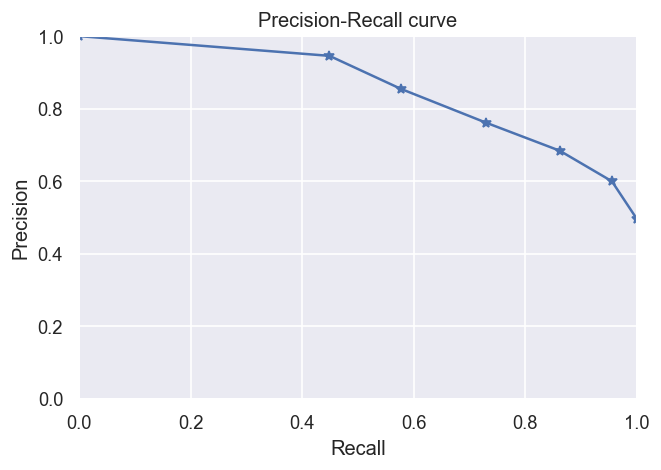

In [464]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_proba[:, 1])
plt.plot(recall, precision, '*-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.xlim([0, 1])
plt.ylim([0, 1])

In [465]:
print(f'The area under the precision-recall curve is: {metrics.auc(recall, precision)}')
print(f'The threshold for the model is {thresholds[-1]}')
print(f'The probability for the model is {pos_proba[-1] > thresholds[-1]}')
print('The AUC Score is: ', metrics.roc_auc_score(y_test, pos_proba))

The area under the precision-recall curve is: 0.855076600571217
The threshold for the model is 1.0
The probability for the model is False
The AUC Score is:  0.8374605496713314


#### 4.6 Model 6 : RandomForestClassifier

In [466]:
rforest = RandomForestClassifier(n_estimators=100, random_state=42)

In [467]:
rforest.fit(X_train, y_train)
y_pred = rforest.predict(X_test)
print(f'The accuracy model: {metrics.accuracy_score(y_test, y_pred)}')

The accuracy model: 0.7708043417756749


In [468]:
metrics.confusion_matrix(y_test, y_pred)

array([[10996,  3525],
       [ 3063, 11160]], dtype=int64)

Text(0, 0.5, 'Frequency')

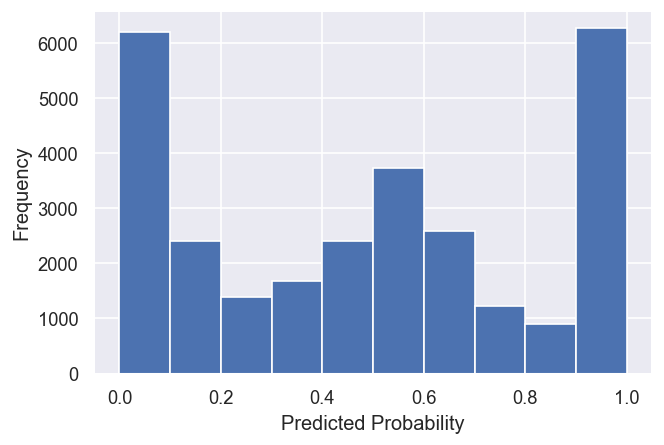

In [469]:
y_pred_proba = rforest.predict_proba(X_test)
pos_proba = y_pred_proba[:, 1]
plt.hist(pos_proba)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

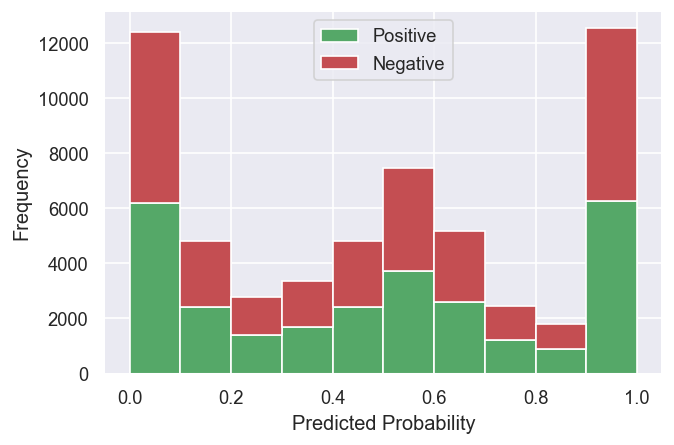

In [470]:
pos_sample_pos_proba = pos_proba[pd.DataFrame(y_test == 1).reset_index()['cancellation'].index.tolist()]
neg_sample_pos_proba = pos_proba[pd.DataFrame(y_test == 0).reset_index()['cancellation'].index.tolist()]

plt.hist([pos_sample_pos_proba, neg_sample_pos_proba], stacked=True, color=['g', 'r'])
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend(['Positive', 'Negative'])

Text(0.5, 1.0, 'ROC curve')

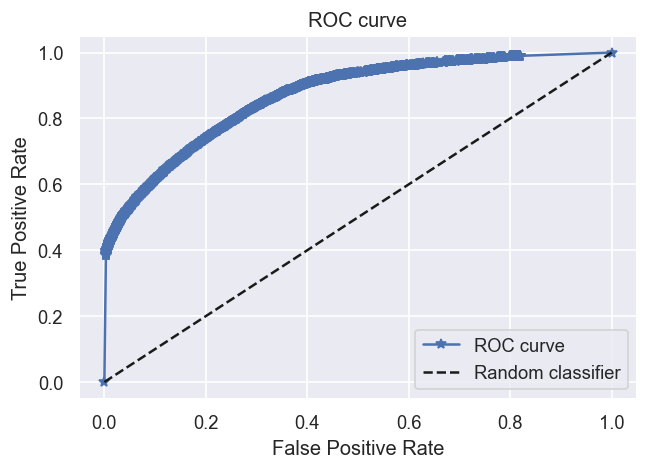

In [471]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, '*-')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(['ROC curve', 'Random classifier'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

(0.0, 1.0)

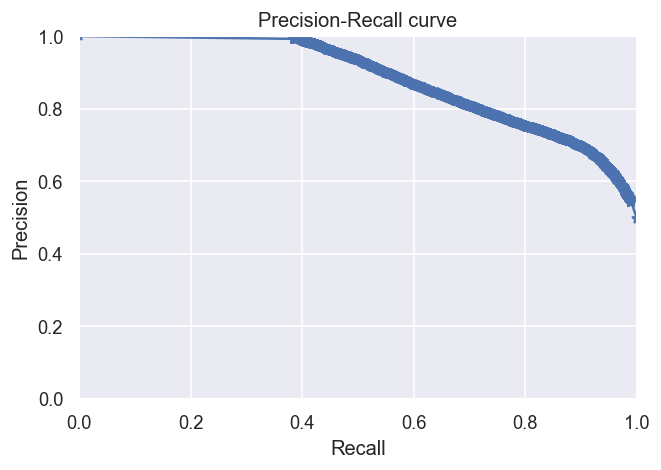

In [472]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_proba[:, 1])
plt.plot(recall, precision, '*-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.xlim([0, 1])
plt.ylim([0, 1])

In [473]:
print(f'The area under the precision-recall curve is: {metrics.auc(recall, precision)}')
print(f'The threshold for the model is {thresholds[-1]}')
print(f'The probability for the model is {pos_proba[-1] > thresholds[-1]}')
print('The AUC Score is: ', metrics.roc_auc_score(y_test, pos_proba))

The area under the precision-recall curve is: 0.880954352587494
The threshold for the model is 1.0
The probability for the model is False
The AUC Score is:  0.8683370257118718


### 5 DEPLOY MODEL DEVELOPMENT: XGBoost

#### 5.1 Grid CV and Cross Validation

In [474]:
cv = GridSearchCV(XGBClassifier(),
                  param_grid={'max_depth': [3, 5, 7],
                              'n_estimators': [50, 100, 200],
                              'learning_rate': [0.1, 0.3, 0.5]},
                  scoring='roc_auc',
                  cv=5,
                  n_jobs=-1)

In [475]:
cv.fit(X_train, y_train)

[22:16:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

In [476]:
cv_results_df = pd.DataFrame(cv.cv_results_)
cv_results_df.sort_values(by='rank_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.470807,0.150790,0.039662,0.002935,0.1,3,50,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.821360,0.824791,0.826101,0.823314,0.817153,0.822544,0.003123,27
1,4.639054,0.266160,0.039794,0.004592,0.1,3,100,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.827114,0.831065,0.833247,0.829164,0.825420,0.829202,0.002775,26
9,2.004127,0.026375,0.032238,0.001673,0.3,3,50,"{'learning_rate': 0.3, 'max_depth': 3, 'n_esti...",0.829590,0.835270,0.836066,0.830887,0.827514,0.831866,0.003295,25
3,3.623398,0.039744,0.039401,0.006086,0.1,5,50,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.830205,0.835041,0.835957,0.832667,0.828242,0.832422,0.002891,24
2,8.000617,0.082467,0.042975,0.004243,0.1,3,200,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.831101,0.837054,0.839330,0.834130,0.831397,0.834602,0.003198,23
18,2.146889,0.030601,0.034514,0.001231,0.5,3,50,"{'learning_rate': 0.5, 'max_depth': 3, 'n_esti...",0.834163,0.840564,0.841154,0.838212,0.834180,0.837655,0.003010,22
4,6.925552,0.138105,0.045405,0.004035,0.1,5,100,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.835846,0.841099,0.842025,0.838115,0.834397,0.838296,0.002933,21
6,5.219802,0.071318,0.040199,0.002992,0.1,7,50,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.836546,0.840942,0.843564,0.838882,0.835810,0.839149,0.002853,20
10,4.256781,0.173261,0.040828,0.003658,0.3,3,100,"{'learning_rate': 0.3, 'max_depth': 3, 'n_esti...",0.837068,0.841811,0.843949,0.839520,0.836140,0.839698,0.002903,19
12,3.502829,0.068637,0.037600,0.002245,0.3,5,50,"{'learning_rate': 0.3, 'max_depth': 5, 'n_esti...",0.839722,0.845009,0.848767,0.844296,0.840234,0.843605,0.003333,18


In [477]:
cv.best_params_

{'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 200}

In [478]:
features_importance = pd.DataFrame(cv.best_estimator_.feature_importances_, index=X_train.columns, columns=['importance']).sort_values(by='importance', ascending=False)

In [479]:
features_importance

,importance
map_deposit_policy,0.805630
black_list,0.109812
market_segment_2,0.020846
repeated_guest,0.012838
customer_type,0.008905
days_between_booking_arrival,0.007924
market_segment_1,0.005842
market_segment_5,0.005347
market_segment_3,0.004777
num_adults,0.004270


#### 5.2 Modeling with parameters

In [480]:
model = XGBClassifier(  learning_rate= 0.5,
                        max_depth= 7,
                        n_estimators= 200,
                        )


In [481]:

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'The accuracy model: {metrics.accuracy_score(y_test, y_pred)}')

[22:16:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The accuracy model: 0.7794322293348177


In [482]:
metrics.confusion_matrix(y_test, y_pred)

array([[11063,  3458],
       [ 2882, 11341]], dtype=int64)

Text(0, 0.5, 'Frequency')

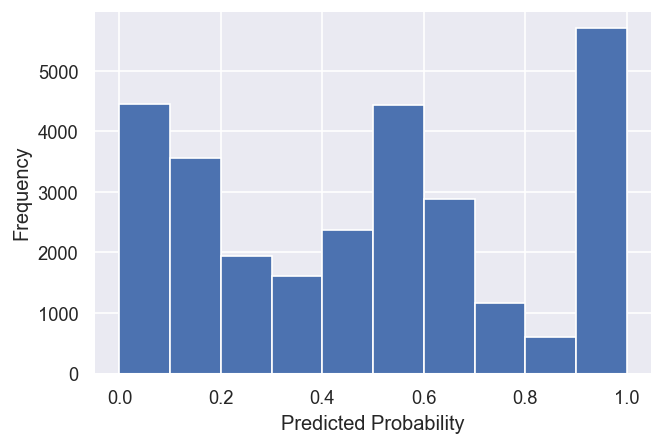

In [483]:
y_pred_proba = model.predict_proba(X_test)
pos_proba = y_pred_proba[:, 1]
plt.hist(pos_proba)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

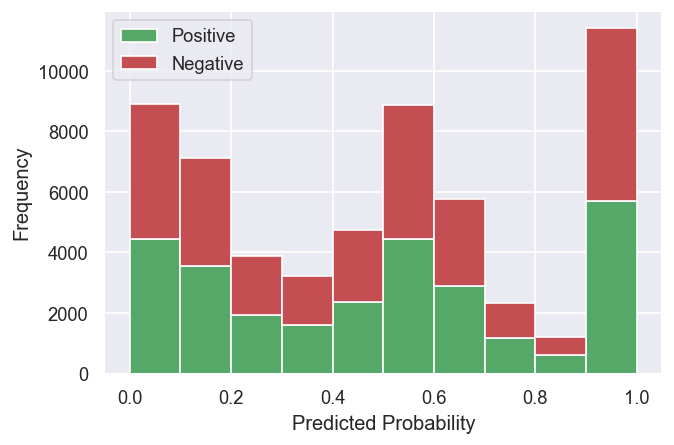

In [484]:
pos_sample_pos_proba = pos_proba[pd.DataFrame(y_test == 1).reset_index()['cancellation'].index.tolist()]
neg_sample_pos_proba = pos_proba[pd.DataFrame(y_test == 0).reset_index()['cancellation'].index.tolist()]

plt.hist([pos_sample_pos_proba, neg_sample_pos_proba], stacked=True, color=['g', 'r'])
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend(['Positive', 'Negative'])

Text(0.5, 1.0, 'ROC curve')

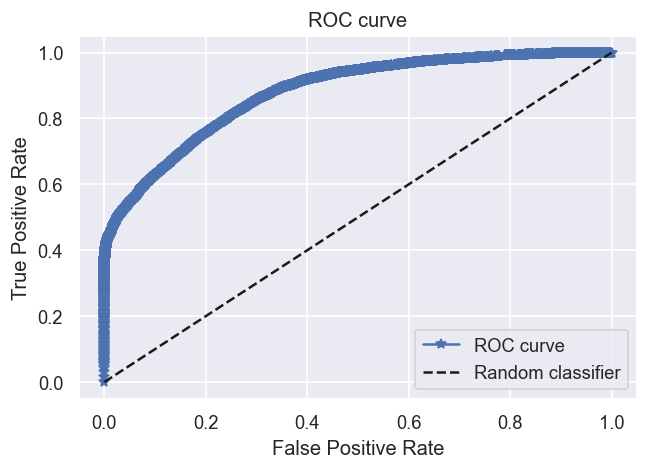

In [485]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, '*-')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(['ROC curve', 'Random classifier'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

(0.0, 1.0)

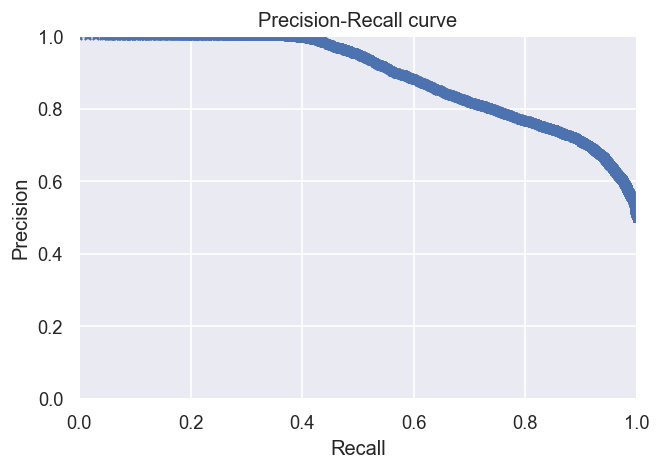

In [486]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_proba[:, 1])
plt.plot(recall, precision, '*-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.xlim([0, 1])
plt.ylim([0, 1])

In [487]:
print(f'The area under the precision-recall curve is: {metrics.auc(recall, precision)}')
print(f'The threshold for the model is {thresholds[-1]}')
print(f'The probability for the model is {pos_proba[-1] > thresholds[-1]}')
print('The AUC Score is: ', metrics.roc_auc_score(y_test, pos_proba))

The area under the precision-recall curve is: 0.8902809639906883
The threshold for the model is 1.0
The probability for the model is False
The AUC Score is:  0.878550080497624


#### 5.3 Modeling reduced features

In [488]:
list_keep_columns = features_importance.head().index.tolist()

In [489]:
X_train_reduced = X_train[list_keep_columns]
X_test_reduced = X_test[list_keep_columns]

In [490]:
model_reduced = XGBClassifier(learning_rate=0.5,
                      max_depth=7,
                      n_estimators=200,
                      )

model_reduced.fit(X_train_reduced, y_train)
y_pred = model_reduced.predict(X_test_reduced)
print(f'The accuracy model: {metrics.accuracy_score(y_test, y_pred)}')

[22:16:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The accuracy model: 0.7002504870581686


In [491]:
metrics.confusion_matrix(y_test, y_pred)

array([[ 8543,  5978],
       [ 2638, 11585]], dtype=int64)

Text(0, 0.5, 'Frequency')

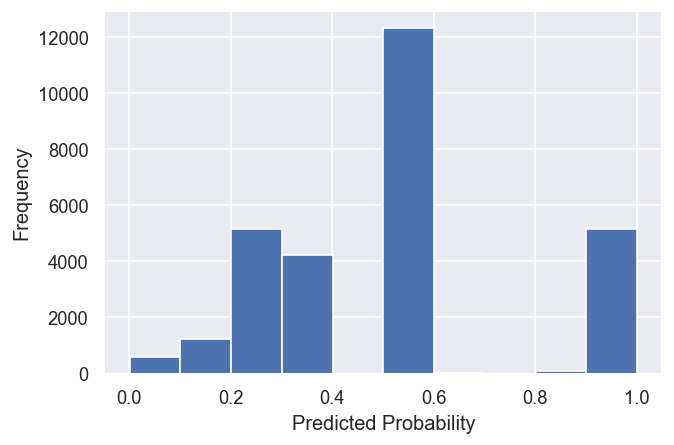

In [492]:
y_pred_proba = model_reduced.predict_proba(X_test_reduced)
pos_proba = y_pred_proba[:, 1]
plt.hist(pos_proba)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

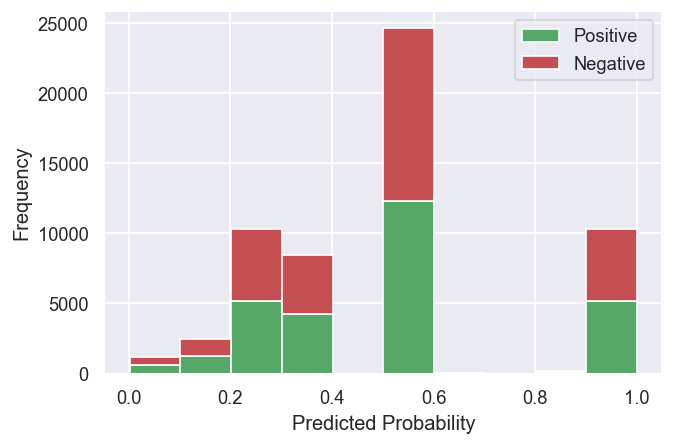

In [493]:
pos_sample_pos_proba = pos_proba[pd.DataFrame(y_test == 1).reset_index()['cancellation'].index.tolist()]
neg_sample_pos_proba = pos_proba[pd.DataFrame(y_test == 0).reset_index()['cancellation'].index.tolist()]

plt.hist([pos_sample_pos_proba, neg_sample_pos_proba], stacked=True, color=['g', 'r'])
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend(['Positive', 'Negative'])

Text(0.5, 1.0, 'ROC curve')

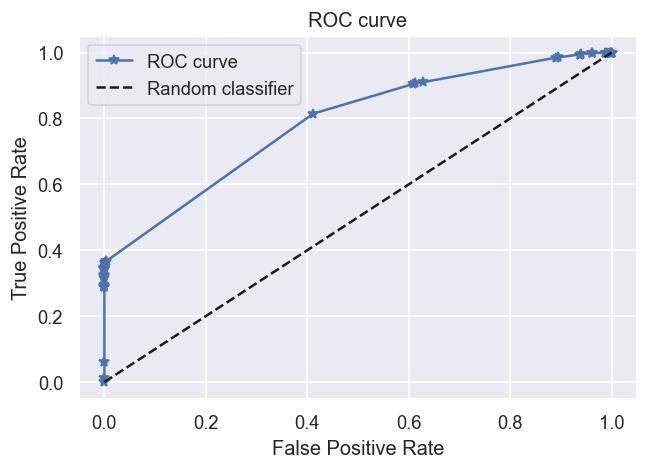

In [494]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, '*-')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(['ROC curve', 'Random classifier'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

(0.0, 1.0)

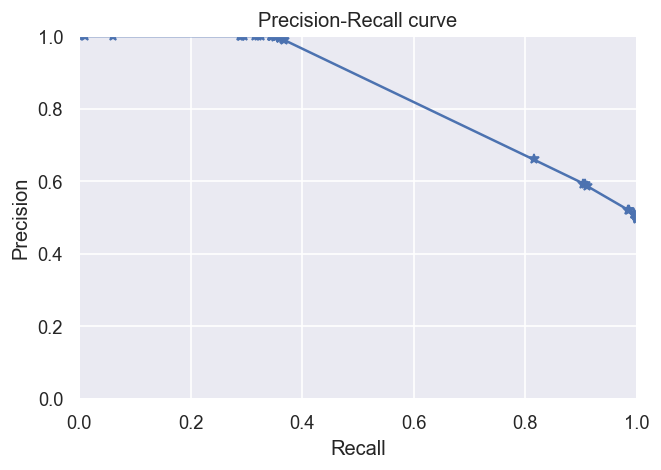

In [495]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_proba[:, 1])
plt.plot(recall, precision, '*-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.xlim([0, 1])
plt.ylim([0, 1])

In [496]:
print(f'The area under the precision-recall curve is: {metrics.auc(recall, precision)}')
print(f'The threshold for the model is {thresholds[-1]}')
print(f'The probability for the model is {pos_proba[-1] > thresholds[-1]}')
print('The AUC Score is: ', metrics.roc_auc_score(y_test, pos_proba))

The area under the precision-recall curve is: 0.8447106638718385
The threshold for the model is 0.9999973773956299
The probability for the model is False
The AUC Score is:  0.7867249798061738


#### 5.4 Verifying best threshold

In [497]:
from sklearn.metrics import precision_recall_curve
from numpy import argmax
from sklearn.metrics import classification_report


Best Threshold=0.389863, F-Score=0.795


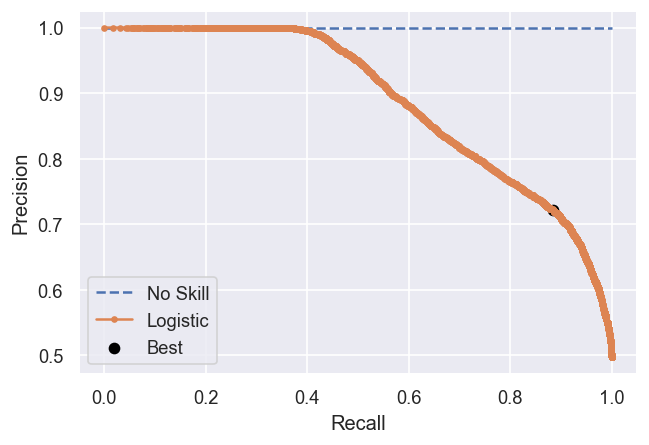

In [498]:
yhat = model.predict_proba(X_test)
yhat = yhat[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, yhat)
fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
best_threshold = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [499]:
y_pred_ba=model.predict_proba(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.59      0.66     14521
           1       0.66      0.81      0.73     14223

    accuracy                           0.70     28744
   macro avg       0.71      0.70      0.70     28744
weighted avg       0.71      0.70      0.70     28744



In [500]:
# New Threashold

In [505]:
threshold=best_threshold
pred2=pd.Series(y_pred_ba[:,1]).map(lambda x: 1 if x > threshold else 0)
print(classification_report(y_test, pred2))


              precision    recall  f1-score   support

           0       0.85      0.67      0.75     14521
           1       0.72      0.88      0.80     14223

    accuracy                           0.77     28744
   macro avg       0.79      0.78      0.77     28744
weighted avg       0.79      0.77      0.77     28744



In [506]:
metrics.confusion_matrix(y_test, pred2)

array([[ 9683,  4838],
       [ 1647, 12576]], dtype=int64)

#### 5.4 Model deploy

In [502]:
import pickle

#save model to disk
pickle.dump(model, open('../models/model.pkl', 'wb'))

In [514]:
X_test.iloc[:10].to_csv('../data/X_test.csv', index=False)